# Feature Extraction using Convolutional Neural Networks
[GitHub Tutorial:CIFAR 10 feature extraction using pretrained convolutional depp neural networks from keras library](https://github.com/rnoxy/cifar10-cnn/blob/master/Feature_extraction_using_keras.ipynb)

In [1]:
#Github code
network_names = [ 'incv3', 'resnet50', 'vgg16', 'vgg19' ]

print("Available networks = ", network_names)
cnnid = int( input("Please choose the CNN network [0-{n}]: ".format(n=len(network_names)-1)) )
selected_network = network_names[cnnid]
print("Selected network: ", selected_network)

Available networks =  ['incv3', 'resnet50', 'vgg16', 'vgg19']
Please choose the CNN network [0-3]: 1
Selected network:  resnet50


In [2]:
 pip install myutils

  Created wheel for myutils: filename=myutils-0.0.21-py3-none-any.whl size=1364 sha256=ceb1d65471fce58fbf73f1ccde68aa239ebb6d2558c2febc24869866e7efce65
  Stored in directory: /root/.cache/pip/wheels/8e/89/9f/ab7f23dcc9ba30d64a298bcfc29c4e7e9ec59110ddc69aac12
Successfully built myutils


In [3]:
#github
import time
import myutils
import numpy as np
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from keras.layers import Input, Dense, AveragePooling2D, GlobalAveragePooling2D, Conv2D
from keras import backend as K

Instructions for updating:
non-resource variables are not supported in the long term


## Load CIFAR10 data

169017344/169001437 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


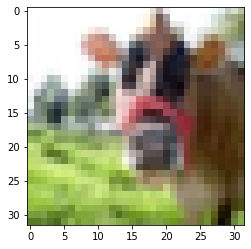

In [4]:
#github
from keras.datasets import cifar100
(X_train, y_train), (X_test, y_test) = cifar100.load_data()

n_training = X_train.shape[0]
n_testing = X_test.shape[0]

y_train = y_train.flatten()
y_test  = y_test.flatten()

print( X_train.shape, y_train.shape,  X_test.shape, y_test.shape )

from matplotlib import pyplot as plt
plt.imshow( X_train[0]  )
plt.show()

## Create model

In [5]:
#github
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet     import ResNet50
from keras.applications.vgg16        import VGG16
from keras.applications.vgg19        import VGG19

input_shape = {
    'incv3'   : (299,299,3),
    'resnet50': (224,224,3),
    'vgg16'   : (224,224,3),
    'vgg19'   : (224,224,3)
}[selected_network]

def create_model_incv3():
    tf_input = Input(shape=input_shape)
    model = InceptionV3(input_tensor=tf_input, weights='imagenet', include_top=False)
    output_pooled = AveragePooling2D((8, 8), strides=(8, 8))(model.output)
    return Model(model.input, output_pooled)

def create_model_resnet50():
    tf_input = Input(shape=input_shape)
    model = ResNet50(input_tensor=tf_input, include_top=False)
    convolutional_layer = Conv2D(100,1)(model.output)
    output_pooled = AveragePooling2D((7, 7))(convolutional_layer)
    return Model(model.input, output_pooled )

def create_model_vgg16():
    tf_input = Input(shape=input_shape)
    model = VGG16(input_tensor=tf_input, include_top=False)
    output_pooled = AveragePooling2D((7, 7))(model.output)
    return Model(model.input, output_pooled )

def create_model_vgg19():
    tf_input = Input(shape=input_shape)
    model = VGG19(input_tensor=tf_input, include_top=False)
    convolutional_layer = Conv2D(100,1)(model.output)
    output_pooled = AveragePooling2D((7, 7))(convolutional_layer)
    return Model(model.input, output_pooled )

create_model = {
    'incv3'    : create_model_incv3,
    'resnet50' : create_model_resnet50,
    'vgg16'    : create_model_vgg16,
    'vgg19'    : create_model_vgg19
}[selected_network]

## Data generator for tensorflow

[Tensorflow 1 to 2](https://stackoverflow.com/questions/60966376/best-practice-to-write-code-compatible-to-both-tensorflow-1-and-2)

In [6]:
#github
# tensorflow placeholder for batch of images from CIFAR10 dataset
batch_of_images_placeholder = tf.placeholder("uint8", (None, 32, 32, 3))

batch_size = {
    'incv3'    : 16,
    'resnet50' : 16,
    'vgg16'    : 16,
    'vgg19'    : 16
}[selected_network]

# Inception default size is 299x299
tf_resize_op = tf.image.resize(batch_of_images_placeholder, (input_shape[:2]), method='bilinear')

In [7]:
#github
# data generator for tensorflow session
from keras.applications.inception_v3 import preprocess_input as incv3_preprocess_input
from keras.applications.resnet     import preprocess_input as resnet50_preprocess_input
from keras.applications.vgg16        import preprocess_input as vgg16_preprocess_input
from keras.applications.vgg19        import preprocess_input as vgg19_preprocess_input

preprocess_input = {
    'incv3'   : incv3_preprocess_input,
    'resnet50': resnet50_preprocess_input,
    'vgg16'   : vgg16_preprocess_input,
    'vgg19'   : vgg19_preprocess_input
}[selected_network]

def data_generator(sess,data,labels):
    def generator():
        start = 0
        end = start + batch_size
        n = data.shape[0]
        while True:
            batch_of_images_resized = sess.run(tf_resize_op, {batch_of_images_placeholder: data[start:end]})
            batch_of_images__preprocessed = preprocess_input(batch_of_images_resized)
            batch_of_labels = labels[start:end]
            start += batch_size
            end   += batch_size
            if start >= n:
                start = 0
                end = batch_size
            yield (batch_of_images__preprocessed, batch_of_labels)
    return generator

## Feature extraction

In [ ]:
with tf.Session() as sess:
    # setting tensorflow session to Keras
    K.set_session(sess)
    # setting phase to training
    K.set_learning_phase(1)  # 0 - test,  1 - train

    model = create_model()

    data_train_gen = data_generator(sess, X_train, y_train)
    ftrs_training = model.predict_generator(data_train_gen(), n_training/batch_size, verbose=1)

    data_test_gen = data_generator(sess, X_test, y_test)
    ftrs_testing = model.predict_generator(data_test_gen(), n_testing/batch_size, verbose=1)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.7/dist-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
#github
features_training = np.array( [ftrs_training[i].flatten() for i in range(n_training)] )
features_testing  = np.array( [ftrs_testing[i].flatten()  for i in range(n_testing )] )

#np.savez_compressed("features/CIFAR10_{}-keras_features.npz".format(selected_network),features_training=features_training,features_testing=features_testing,labels_training=y_train,labels_testing=y_test)

## Feature visualization

### Feature analysis (using PCA)

In [ ]:
#github
import numpy as np
import myutils

#data = np.load("features/CIFAR10_{}-keras_features.npz".format(selected_network))

X_training = features_training
y_training = y_train

X_testing = features_testing
y_testing = y_test

# data_training, data_testing = myutils.load_CIFAR_dataset(shuffle=False)
# assert( (np.array( [data_training[i][1] for i in range(len(data_training))] ) == y_training).all() )
# assert( (np.array( [data_testing[i][1] for i in range(len(data_testing))] ) == y_testing).all() )
print( 'X_training size = {}'.format(X_training.shape))

X_training size = (50000, 100)


In [ ]:
import pandas as pd
y_training_1=np.reshape(y_training,(50000,1))
y_testing_1=np.reshape(y_testing,(10000,1))
data_train= np.concatenate((X_training,y_training_1),axis=1)
data_test= np.concatenate((X_testing,y_testing_1),axis=1)
df_train=pd.DataFrame(data=data_train)
df_test=pd.DataFrame(data=data_test)

In [ ]:
df_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,0.517897,-0.767380,-2.015000,-2.110868,0.263989,-0.264965,-0.284467,0.706627,-1.083511,-0.084309,-0.365202,-0.734645,-0.151511,0.195151,-0.348932,-1.269319,-1.595326,2.218165,0.446715,-0.502543,-2.079332,0.012278,0.165036,0.601960,-0.656955,-2.168468,1.521489,-0.734306,1.947195,-0.377590,-1.060589,0.086344,1.055779,-0.499966,0.538999,-1.371076,-0.853690,1.745685,0.742885,0.129857,...,-0.034631,0.417100,0.860036,0.490977,-2.394185,-1.065900,0.219039,-0.960096,-0.020158,-1.246312,0.583485,-0.259987,-2.196289,-1.658855,0.484258,-0.459433,0.903924,-0.882851,0.383702,-0.280812,-0.900870,-0.353586,-0.384990,-0.605512,1.663711,0.965576,-0.840781,0.629125,1.353969,-0.071695,-2.300732,0.603849,0.577465,-2.052685,-0.397169,-0.693382,0.314917,-1.797599,1.202595,19.0
1,-0.292338,-0.104159,0.225370,-1.363546,-0.281336,0.758676,-0.926789,1.559476,-1.150750,-1.034261,0.596555,-0.041349,0.153397,0.699954,-0.499662,-2.043173,-1.899920,1.226092,0.331600,0.090465,-1.433561,0.158067,0.370795,-0.151882,0.405310,0.351052,0.449367,-0.281205,-0.297653,-0.757165,0.193134,-1.175786,0.530524,-0.169755,-0.118837,-1.091902,-0.429029,-0.418921,0.835056,0.208516,...,0.382061,0.797778,0.249333,-0.721378,-1.390842,-0.530309,0.047709,0.006980,0.963600,-0.185702,0.167626,0.754915,-0.767163,-0.983181,-0.407424,0.478246,1.299986,-1.515887,1.060017,0.358065,1.501573,0.694042,-0.483849,0.343340,0.698956,0.774982,-0.378457,-0.330404,0.392087,0.479169,-0.508334,0.503615,-0.873091,-0.483952,-0.439041,-0.376849,0.228433,-0.283825,0.837812,29.0
2,0.158156,0.164518,-0.330229,0.422011,-1.828234,-0.061129,0.457877,2.381633,-1.190944,-0.378902,0.142264,-0.306347,0.167808,-0.673831,0.261408,-0.624670,-1.125607,-0.492904,0.850371,0.261290,-0.223733,0.787114,0.177633,0.679380,0.276088,-1.405480,0.091559,0.055065,-0.158278,-0.148044,-0.360869,0.300430,-0.555318,0.152324,0.095144,0.301709,-0.987039,-0.658882,1.653067,-0.189801,...,0.188088,0.262151,0.575633,-0.459541,-0.680122,0.248956,1.247307,-1.437506,-0.545473,-0.491733,0.410399,-0.097867,0.137412,-0.782308,-0.291890,0.228309,1.207397,-0.247267,0.810394,1.054680,-0.821085,1.287938,0.086114,-0.334759,0.176352,1.132015,1.825045,1.591849,1.775765,-0.944531,-0.283281,-0.838388,-0.719638,-1.115687,0.104996,0.571253,-0.010211,-0.549578,0.198618,0.0
3,0.921416,0.467254,0.311154,-0.293623,-0.624900,-0.008182,0.279082,1.644011,-1.102285,0.212121,-0.503502,-1.818379,-1.287280,0.393517,1.549832,-0.518414,-1.610528,2.042588,-0.595250,-0.712579,-0.555824,-0.466308,0.545934,0.932707,-0.508834,-0.369702,-0.100760,-0.098118,1.168031,0.213278,0.103440,0.194799,-0.775393,0.719176,1.089635,-1.418252,-0.624478,0.534729,1.088913,0.669241,...,0.766626,2.208750,0.503494,-1.015058,-2.338757,-0.856645,0.585124,-0.440480,-0.272542,-0.355037,1.159020,-1.440709,-0.198656,-0.420524,-0.368276,-0.047190,1.279934,0.186641,0.200944,0.048863,0.750358,-0.910189,0.377750,-0.174050,1.494911,1.722302,-0.292135,-0.175946,0.886099,-1.267518,-1.921833,0.204936,-1.628553,-0.499374,-0.800150,-0.134713,-0.930732,-1.702516,0.722438,11.0
4,0.062274,-0.628851,0.259231,-2.167168,0.846353,-1.252747,-0.629963,1.381228,-0.651262,0.774321,-0.312702,-0.820125,0.535881,0.442527,0.270006,-0.597905,-1.360073,2.065471,0.766250,0.126439,0.088324,0.379003,-0.392195,0.424599,0.737031,-1.160711,-1.113153,-1.334770,-0.252146,0.114488,0.484275,0.166793,0.284052,-0.821540,0.577852,-2.812530,-1.233703,-0.114822,0.694046,0.121665,...,1.430171,0.923661,1.680208,-1.506101,-1.155495,0.210134,0.682493,-0.006395,-0.606398,0.537575,0.904624,0.499925,-0.983745,-1.430180,-0.018155,0.047045,0.835751,-0.210533,1.733788,0.481758,-0.564664,-0.054294,-0.089068,-0.430477,0.940682,1.335170,-1.779984,0.498255,0.559621,1.539532,-1.127952,1.612873,0.691252,-1.880153,0.21618

In [ ]:
df_train_final=df_train.rename({100:'Class Label'},axis=1)
df_train_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,Class Label
0,0.517897,-0.767380,-2.015000,-2.110868,0.263989,-0.264965,-0.284467,0.706627,-1.083511,-0.084309,-0.365202,-0.734645,-0.151511,0.195151,-0.348932,-1.269319,-1.595326,2.218165,0.446715,-0.502543,-2.079332,0.012278,0.165036,0.601960,-0.656955,-2.168468,1.521489,-0.734306,1.947195,-0.377590,-1.060589,0.086344,1.055779,-0.499966,0.538999,-1.371076,-0.853690,1.745685,0.742885,0.129857,...,-0.034631,0.417100,0.860036,0.490977,-2.394185,-1.065900,0.219039,-0.960096,-0.020158,-1.246312,0.583485,-0.259987,-2.196289,-1.658855,0.484258,-0.459433,0.903924,-0.882851,0.383702,-0.280812,-0.900870,-0.353586,-0.384990,-0.605512,1.663711,0.965576,-0.840781,0.629125,1.353969,-0.071695,-2.300732,0.603849,0.577465,-2.052685,-0.397169,-0.693382,0.314917,-1.797599,1.202595,19.0
1,-0.292338,-0.104159,0.225370,-1.363546,-0.281336,0.758676,-0.926789,1.559476,-1.150750,-1.034261,0.596555,-0.041349,0.153397,0.699954,-0.499662,-2.043173,-1.899920,1.226092,0.331600,0.090465,-1.433561,0.158067,0.370795,-0.151882,0.405310,0.351052,0.449367,-0.281205,-0.297653,-0.757165,0.193134,-1.175786,0.530524,-0.169755,-0.118837,-1.091902,-0.429029,-0.418921,0.835056,0.208516,...,0.382061,0.797778,0.249333,-0.721378,-1.390842,-0.530309,0.047709,0.006980,0.963600,-0.185702,0.167626,0.754915,-0.767163,-0.983181,-0.407424,0.478246,1.299986,-1.515887,1.060017,0.358065,1.501573,0.694042,-0.483849,0.343340,0.698956,0.774982,-0.378457,-0.330404,0.392087,0.479169,-0.508334,0.503615,-0.873091,-0.483952,-0.439041,-0.376849,0.228433,-0.283825,0.837812,29.0
2,0.158156,0.164518,-0.330229,0.422011,-1.828234,-0.061129,0.457877,2.381633,-1.190944,-0.378902,0.142264,-0.306347,0.167808,-0.673831,0.261408,-0.624670,-1.125607,-0.492904,0.850371,0.261290,-0.223733,0.787114,0.177633,0.679380,0.276088,-1.405480,0.091559,0.055065,-0.158278,-0.148044,-0.360869,0.300430,-0.555318,0.152324,0.095144,0.301709,-0.987039,-0.658882,1.653067,-0.189801,...,0.188088,0.262151,0.575633,-0.459541,-0.680122,0.248956,1.247307,-1.437506,-0.545473,-0.491733,0.410399,-0.097867,0.137412,-0.782308,-0.291890,0.228309,1.207397,-0.247267,0.810394,1.054680,-0.821085,1.287938,0.086114,-0.334759,0.176352,1.132015,1.825045,1.591849,1.775765,-0.944531,-0.283281,-0.838388,-0.719638,-1.115687,0.104996,0.571253,-0.010211,-0.549578,0.198618,0.0
3,0.921416,0.467254,0.311154,-0.293623,-0.624900,-0.008182,0.279082,1.644011,-1.102285,0.212121,-0.503502,-1.818379,-1.287280,0.393517,1.549832,-0.518414,-1.610528,2.042588,-0.595250,-0.712579,-0.555824,-0.466308,0.545934,0.932707,-0.508834,-0.369702,-0.100760,-0.098118,1.168031,0.213278,0.103440,0.194799,-0.775393,0.719176,1.089635,-1.418252,-0.624478,0.534729,1.088913,0.669241,...,0.766626,2.208750,0.503494,-1.015058,-2.338757,-0.856645,0.585124,-0.440480,-0.272542,-0.355037,1.159020,-1.440709,-0.198656,-0.420524,-0.368276,-0.047190,1.279934,0.186641,0.200944,0.048863,0.750358,-0.910189,0.377750,-0.174050,1.494911,1.722302,-0.292135,-0.175946,0.886099,-1.267518,-1.921833,0.204936,-1.628553,-0.499374,-0.800150,-0.134713,-0.930732,-1.702516,0.722438,11.0
4,0.062274,-0.628851,0.259231,-2.167168,0.846353,-1.252747,-0.629963,1.381228,-0.651262,0.774321,-0.312702,-0.820125,0.535881,0.442527,0.270006,-0.597905,-1.360073,2.065471,0.766250,0.126439,0.088324,0.379003,-0.392195,0.424599,0.737031,-1.160711,-1.113153,-1.334770,-0.252146,0.114488,0.484275,0.166793,0.284052,-0.821540,0.577852,-2.812530,-1.233703,-0.114822,0.694046,0.121665,...,1.430171,0.923661,1.680208,-1.506101,-1.155495,0.210134,0.682493,-0.006395,-0.606398,0.537575,0.904624,0.499925,-0.983745,-1.430180,-0.018155,0.047045,0.835751,-0.210533,1.733788,0.481758,-0.564664,-0.054294,-0.089068,-0.430477,0.940682,1.335170,-1.779984,0.498255,0.559621,1.539532,-1.127952,1.612873,0.691252,-1.880153

In [ ]:
df_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100
0,-0.160710,-0.118609,1.364182,-3.325208,-1.519649,0.455779,-2.368366,0.711584,-1.015519,-0.540396,-0.497346,-0.923890,-0.276280,-0.823559,-0.029126,-2.261590,-0.846618,2.156816,-0.350168,0.642213,-0.280791,0.044314,0.405200,-0.865613,0.411640,-3.113644,0.943493,-1.365490,0.490469,0.104446,-0.803751,-0.184904,0.224562,-0.470723,0.881080,-0.249036,-1.299316,0.718931,1.608636,-0.122484,...,-0.445097,0.161314,1.505180,-0.002777,-2.103097,-0.106423,1.340442,-2.657908,0.616227,0.590493,1.776151,-0.382500,-1.319680,0.136765,-1.925781,0.178902,2.084227,-1.124232,0.541190,-0.304644,-0.743412,0.522064,1.039206,-1.502068,1.705752,2.660217,0.412276,0.351644,0.996807,0.459475,-0.997015,-0.432137,0.018045,-0.701094,-0.233964,-0.722854,0.857195,-1.502313,0.909890,49.0
1,0.166452,0.334963,-0.213449,-0.846047,0.630586,-0.184569,-0.853100,0.263814,-0.956922,0.208006,-0.181968,-0.699991,-1.636825,1.236273,0.016668,-0.220570,-0.689279,2.005654,1.131993,0.137635,-1.619548,0.757269,-0.175581,0.355438,0.517269,-1.640224,1.916084,-0.338684,0.977703,-0.510236,0.715616,1.001289,-0.475830,-1.415255,1.421985,-2.699600,-1.964918,1.407601,1.848496,0.651600,...,1.655081,1.066445,1.471569,0.150134,-1.900584,-1.339599,0.920515,-1.193099,0.367495,0.228106,0.419241,0.188392,-1.481541,-1.106643,-0.324335,-1.300472,0.440690,-0.889160,-0.320265,0.798458,-0.352555,-1.114401,0.689841,-0.550375,2.775970,-0.002987,-1.273435,0.967850,0.895465,-0.241398,-1.218204,0.856852,1.295395,-1.027848,-0.629634,-0.013735,-0.090077,0.581602,1.232205,33.0
2,0.558582,1.541446,0.397468,-2.492163,-0.776286,-0.098033,-0.708430,1.013817,-1.994095,-0.164143,-0.597179,-2.336926,-0.133949,0.326534,0.805396,-2.846269,-1.114425,1.562692,-0.250762,-0.518606,-0.100251,-0.242154,0.786731,0.064497,0.633662,0.297470,0.504565,-1.079875,0.982551,-2.139118,-0.219194,-0.030660,0.056987,0.476430,0.480266,-1.025816,-0.626858,1.712641,1.889956,0.531439,...,0.281858,1.565179,0.181022,-1.721147,-1.673079,0.624039,0.550568,-1.167655,-0.563312,-0.025096,-0.257200,1.446091,0.770519,-0.892172,-0.780245,0.036104,0.443329,-0.886138,2.237225,1.731045,0.735835,-0.063259,0.701514,-0.625181,3.106358,1.105625,-1.321572,1.057481,0.357373,1.363971,-1.367378,0.260213,-1.254812,-1.019176,0.404925,-0.490913,-1.427422,-1.159136,1.676397,72.0
3,-0.207472,-0.117936,-0.279227,-2.071902,-1.116088,2.926582,0.089361,1.457731,-2.067014,1.217302,0.671218,0.140994,0.059471,-0.326366,0.478437,-1.557763,-3.585497,2.466066,1.605204,-0.710113,-0.781831,1.354887,0.554592,0.558173,0.646620,-0.915967,0.251907,-2.202653,-0.168024,-1.138225,-0.498829,-0.485143,-0.208763,-0.972417,1.719444,0.816224,-0.929045,1.416937,1.115993,0.024870,...,1.803807,1.395820,1.463519,-0.460309,-2.142596,-1.426340,0.553050,0.309960,1.112034,-2.129634,1.316025,0.779269,-1.089168,-0.245717,-1.274318,-0.183274,0.610548,-2.003754,0.935638,0.251035,0.778683,-0.745849,0.788969,-1.605941,1.939123,0.412550,-1.847184,1.455943,2.184688,0.920861,-0.300344,1.096133,0.122310,-1.119434,0.849269,0.725462,-0.364626,-1.102366,0.726545,51.0
4,1.018068,1.039858,0.896169,-0.375297,0.397201,1.832428,0.377811,1.700094,-0.980878,0.240338,-0.222904,1.465945,0.567095,0.230141,0.733877,-0.307772,-1.020715,1.967339,1.265025,-0.375136,-1.189892,-0.499118,-0.266051,1.681710,-0.145820,-0.348253,1.672407,-0.696696,-0.671322,-0.968487,-0.452056,0.553913,-0.076591,0.282278,1.306374,-1.041017,-0.946919,0.747737,-0.350327,0.581644,...,-1.453845,1.028023,-1.202844,-0.254025,-0.730877,-0.410654,0.634533,-2.717014,-0.400986,0.632222,-1.001264,-0.317660,-0.701527,0.692208,-0.360302,-0.321926,1.658000,-2.249194,0.924299,1.139480,0.922044,-0.982908,0.291232,-2.081970,0.278599,0.175784,0.831963,1.464601,0.580951,-0.377291,-0.239863,-0.530352,-0.045193,-1.505260,-0.31111

In [ ]:
df_test_final=df_test.rename({100:'Class Label'},axis=1)
df_test_final

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,Class Label
0,-0.160710,-0.118609,1.364182,-3.325208,-1.519649,0.455779,-2.368366,0.711584,-1.015519,-0.540396,-0.497346,-0.923890,-0.276280,-0.823559,-0.029126,-2.261590,-0.846618,2.156816,-0.350168,0.642213,-0.280791,0.044314,0.405200,-0.865613,0.411640,-3.113644,0.943493,-1.365490,0.490469,0.104446,-0.803751,-0.184904,0.224562,-0.470723,0.881080,-0.249036,-1.299316,0.718931,1.608636,-0.122484,...,-0.445097,0.161314,1.505180,-0.002777,-2.103097,-0.106423,1.340442,-2.657908,0.616227,0.590493,1.776151,-0.382500,-1.319680,0.136765,-1.925781,0.178902,2.084227,-1.124232,0.541190,-0.304644,-0.743412,0.522064,1.039206,-1.502068,1.705752,2.660217,0.412276,0.351644,0.996807,0.459475,-0.997015,-0.432137,0.018045,-0.701094,-0.233964,-0.722854,0.857195,-1.502313,0.909890,49.0
1,0.166452,0.334963,-0.213449,-0.846047,0.630586,-0.184569,-0.853100,0.263814,-0.956922,0.208006,-0.181968,-0.699991,-1.636825,1.236273,0.016668,-0.220570,-0.689279,2.005654,1.131993,0.137635,-1.619548,0.757269,-0.175581,0.355438,0.517269,-1.640224,1.916084,-0.338684,0.977703,-0.510236,0.715616,1.001289,-0.475830,-1.415255,1.421985,-2.699600,-1.964918,1.407601,1.848496,0.651600,...,1.655081,1.066445,1.471569,0.150134,-1.900584,-1.339599,0.920515,-1.193099,0.367495,0.228106,0.419241,0.188392,-1.481541,-1.106643,-0.324335,-1.300472,0.440690,-0.889160,-0.320265,0.798458,-0.352555,-1.114401,0.689841,-0.550375,2.775970,-0.002987,-1.273435,0.967850,0.895465,-0.241398,-1.218204,0.856852,1.295395,-1.027848,-0.629634,-0.013735,-0.090077,0.581602,1.232205,33.0
2,0.558582,1.541446,0.397468,-2.492163,-0.776286,-0.098033,-0.708430,1.013817,-1.994095,-0.164143,-0.597179,-2.336926,-0.133949,0.326534,0.805396,-2.846269,-1.114425,1.562692,-0.250762,-0.518606,-0.100251,-0.242154,0.786731,0.064497,0.633662,0.297470,0.504565,-1.079875,0.982551,-2.139118,-0.219194,-0.030660,0.056987,0.476430,0.480266,-1.025816,-0.626858,1.712641,1.889956,0.531439,...,0.281858,1.565179,0.181022,-1.721147,-1.673079,0.624039,0.550568,-1.167655,-0.563312,-0.025096,-0.257200,1.446091,0.770519,-0.892172,-0.780245,0.036104,0.443329,-0.886138,2.237225,1.731045,0.735835,-0.063259,0.701514,-0.625181,3.106358,1.105625,-1.321572,1.057481,0.357373,1.363971,-1.367378,0.260213,-1.254812,-1.019176,0.404925,-0.490913,-1.427422,-1.159136,1.676397,72.0
3,-0.207472,-0.117936,-0.279227,-2.071902,-1.116088,2.926582,0.089361,1.457731,-2.067014,1.217302,0.671218,0.140994,0.059471,-0.326366,0.478437,-1.557763,-3.585497,2.466066,1.605204,-0.710113,-0.781831,1.354887,0.554592,0.558173,0.646620,-0.915967,0.251907,-2.202653,-0.168024,-1.138225,-0.498829,-0.485143,-0.208763,-0.972417,1.719444,0.816224,-0.929045,1.416937,1.115993,0.024870,...,1.803807,1.395820,1.463519,-0.460309,-2.142596,-1.426340,0.553050,0.309960,1.112034,-2.129634,1.316025,0.779269,-1.089168,-0.245717,-1.274318,-0.183274,0.610548,-2.003754,0.935638,0.251035,0.778683,-0.745849,0.788969,-1.605941,1.939123,0.412550,-1.847184,1.455943,2.184688,0.920861,-0.300344,1.096133,0.122310,-1.119434,0.849269,0.725462,-0.364626,-1.102366,0.726545,51.0
4,1.018068,1.039858,0.896169,-0.375297,0.397201,1.832428,0.377811,1.700094,-0.980878,0.240338,-0.222904,1.465945,0.567095,0.230141,0.733877,-0.307772,-1.020715,1.967339,1.265025,-0.375136,-1.189892,-0.499118,-0.266051,1.681710,-0.145820,-0.348253,1.672407,-0.696696,-0.671322,-0.968487,-0.452056,0.553913,-0.076591,0.282278,1.306374,-1.041017,-0.946919,0.747737,-0.350327,0.581644,...,-1.453845,1.028023,-1.202844,-0.254025,-0.730877,-0.410654,0.634533,-2.717014,-0.400986,0.632222,-1.001264,-0.317660,-0.701527,0.692208,-0.360302,-0.321926,1.658000,-2.249194,0.924299,1.139480,0.922044,-0.982908,0.291232,-2.081970,0.278599,0.175784,0.831963,1.464601,0.580951,-0.377291,-0.239863,-0.530352,-0.045193,-1.505260,

In [ ]:
df_train_final.to_csv("TrainingDataCifar100ResnetSize100.csv")

In [ ]:
df_test_final.to_csv("TestingDataCifar100ResnetSize100.csv")

In [ ]:
#github
X = X_training

# Classifier

In [ ]:
from sklearn.preprocessing import LabelBinarizer
#custom code
Y_train=LabelBinarizer().fit_transform(y_training)
Y_test=LabelBinarizer().fit_transform(y_testing)

In [ ]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier()

In [ ]:
#Please see the following website for reference
#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

import numpy as np

# Number of hidden layers for the neural network
hidden_layer_sizes = [(20,),(10,10),(7,7,6),(5,5,5,5),(4,4,4,4,4)]

# activation function for neural network
#x=(a1)x1+(a2)x2+(a3)x3+....(an)(xn) 
#identity: f(x)=x
# logistic: f(x)=
# tanh:
# relu:
activation = ['logistic','tanh','relu']

# Maximum number of levels in tree
solver = ['lbfgs','sgd','adam']

# Minimum number of samples required to split a node
alpha = [0.0005, 0.001,0.005]

# Method of selecting samples for training each tree
learning_rate = ['constant', 'invscaling','adaptive']

# Number of features to consider at every split
power_t = [0.25, 0.5,0.75]

# Maximum number of levels in tree
max_iter = [100,200,300]

# Method of selecting samples for training each tree
tol = [1e-5,1e-4,1e-3]

# Minimum number of samples required to split a node
n_iter_no_change = [10, 50, 100]


# Create the random grid
random_grid = {'hidden_layer_sizes': hidden_layer_sizes,
               'activation': activation,
               'solver': solver,
               'alpha': alpha,
               'learning_rate': learning_rate,
               'power_t': power_t,
               'max_iter': max_iter,
               'tol': tol,
               'n_iter_no_change': n_iter_no_change}
print(random_grid)

{'hidden_layer_sizes': [(20,), (10, 10), (7, 7, 6), (5, 5, 5, 5), (4, 4, 4, 4, 4)], 'activation': ['logistic', 'tanh', 'relu'], 'solver': ['lbfgs', 'sgd', 'adam'], 'alpha': [0.0005, 0.001, 0.005], 'learning_rate': ['constant', 'invscaling', 'adaptive'], 'power_t': [0.25, 0.5, 0.75], 'max_iter': [100, 200, 300], 'tol': [1e-05, 0.0001, 0.001], 'n_iter_no_change': [10, 50, 100]}


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_random= RandomizedSearchCV(estimator=model,param_distributions= random_grid, n_iter=100, cv = 3, verbose=2, n_jobs=-1)

In [ ]:
model_random.fit(X,Y_train)
model_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (20,),
 'learning_rate': 'constant',
 'max_iter': 100,
 'n_iter_no_change': 100,
 'power_t': 0.25,
 'solver': 'adam',
 'tol': 0.0001}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Create the random grid
param_grid = {
 'activation': ['relu'],
 'alpha': [0.0005,0.005],
 'hidden_layer_sizes': [(20,)],
 'learning_rate': ['constant','invscaling'],
 'max_iter': [100,200,300],
 'n_iter_no_change': [10,50,100],
 'power_t': [0.25,0.5],
 'solver': ['adam'],
 'tol': [0.0001]}
print(param_grid)

{'activation': ['relu'], 'alpha': [0.0005, 0.005], 'hidden_layer_sizes': [(20,)], 'learning_rate': ['constant', 'invscaling'], 'max_iter': [100, 200, 300], 'n_iter_no_change': [10, 50, 100], 'power_t': [0.25, 0.5], 'solver': ['adam'], 'tol': [0.0001]}


In [ ]:
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
model_grid= GridSearchCV(estimator=model,param_grid= param_grid, cv = 3, verbose=2, n_jobs=-1)

In [ ]:
model_grid.fit(X,Y_train)
model_grid.best_params_

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


{'activation': 'relu',
 'alpha': 0.0005,
 'hidden_layer_sizes': (20,),
 'learning_rate': 'invscaling',
 'max_iter': 300,
 'n_iter_no_change': 50,
 'power_t': 0.25,
 'solver': 'adam',
 'tol': 0.0001}

In [ ]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier(activation='relu',alpha=0.0005, hidden_layer_sizes=(20,), learning_rate='invscaling',max_iter=300, n_iter_no_change=50, power_t=0.25, solver='adam',tol=0.0001 )


TrainedModel=model.fit(X,Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
X_t = X_testing

# ROC and PRC Curves

## 0-49

### ROC and PRC Curves 0-9 

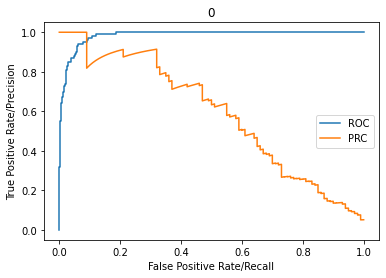

PRC AUC:0.5888193237250717
ROC AUC:0.9837141414141414


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

probs = TrainedModel.predict_proba(X_t)
fpr1, tpr1, thresholds1 = roc_curve(Y_test[:,0], probs[:,0])
prec1, recall1, thresholds1 = precision_recall_curve(Y_test[:,0], probs[:,0])

plt.plot(fpr1,tpr1,label="ROC")
plt.plot(recall1,prec1,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('0')
plt.show()

print("PRC AUC:" + str(auc(recall1, prec1)))
print("ROC AUC:" + str(auc(fpr1, tpr1)))

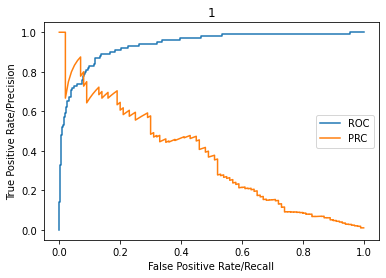

PRC AUC:0.365445461897939
ROC AUC:0.9369333333333332


In [ ]:
fpr2, tpr2, thresholds2 = roc_curve(Y_test[:,1], probs[:, 1])
prec2, recall2, thresholds2 = precision_recall_curve(Y_test[:,1], probs[:, 1])

plt.plot(fpr2,tpr2,label="ROC")
plt.plot(recall2,prec2,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('1')
plt.show()

print("PRC AUC:" + str(auc(recall2, prec2)))
print("ROC AUC:" + str(auc(fpr2, tpr2)))

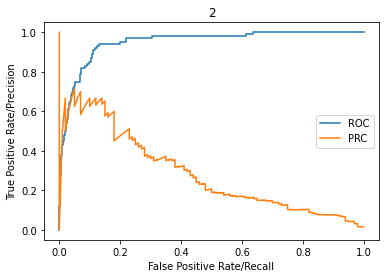

PRC AUC:0.2820388609373632
ROC AUC:0.9493131313131314


In [ ]:
fpr3, tpr3, thresholds3 = roc_curve(Y_test[:,2], probs[:, 2])
prec3, recall3, thresholds3 = precision_recall_curve(Y_test[:,2], probs[:, 2])

plt.plot(fpr3,tpr3,label="ROC")
plt.plot(recall3,prec3,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('2')
plt.show()

print("PRC AUC:" + str(auc(recall3, prec3)))
print("ROC AUC:" + str(auc(fpr3, tpr3)))

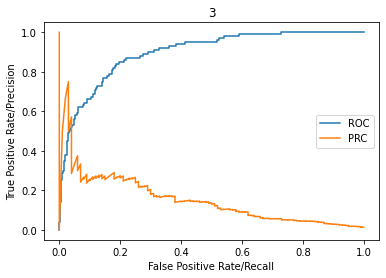

PRC AUC:0.1486974631931959
ROC AUC:0.897279797979798


In [ ]:
fpr4, tpr4, thresholds4 = roc_curve(Y_test[:,3], probs[:, 3])
prec4, recall4, thresholds4 = precision_recall_curve(Y_test[:,3], probs[:, 3])

plt.plot(fpr4,tpr4,label="ROC")
plt.plot(recall4,prec4,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('3')
plt.show()

print("PRC AUC:" + str(auc(recall4, prec4)))
print("ROC AUC:" + str(auc(fpr4, tpr4)))

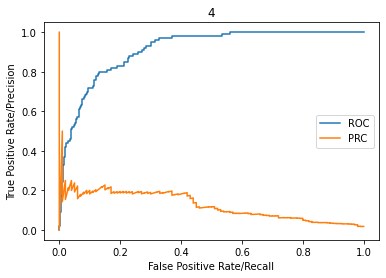

PRC AUC:0.12223751131327246
ROC AUC:0.9123636363636364


In [ ]:
fpr5, tpr5, thresholds5 = roc_curve(Y_test[:,4], probs[:, 4])
prec5, recall5, thresholds5 = precision_recall_curve(Y_test[:,4], probs[:, 4])

plt.plot(fpr5,tpr5,label="ROC")
plt.plot(recall5,prec5,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('4')
plt.show()

print("PRC AUC:" + str(auc(recall5, prec5)))
print("ROC AUC:" + str(auc(fpr5, tpr5)))

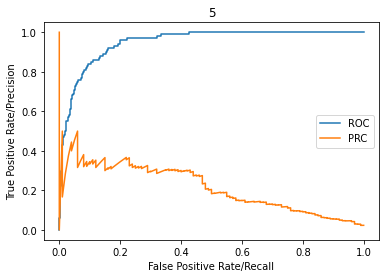

PRC AUC:0.2113836393744435
ROC AUC:0.9488979797979799


In [ ]:
fpr6, tpr6, thresholds6 = roc_curve(Y_test[:,5], probs[:, 5])
prec6, recall6, thresholds6 = precision_recall_curve(Y_test[:,5], probs[:, 5])

plt.plot(fpr6,tpr6,label="ROC")
plt.plot(recall6,prec6,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('5')
plt.show()

print("PRC AUC:" + str(auc(recall6, prec6)))
print("ROC AUC:" + str(auc(fpr6, tpr6)))

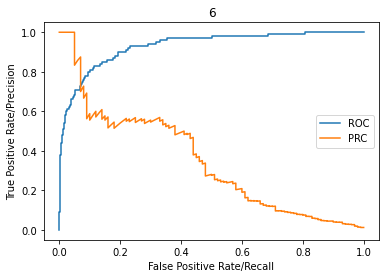

PRC AUC:0.3462533276724041
ROC AUC:0.9304171717171716


In [ ]:
fpr7, tpr7, thresholds7 = roc_curve(Y_test[:,6], probs[:, 6])
prec7, recall7, thresholds7 = precision_recall_curve(Y_test[:,6], probs[:, 6])

plt.plot(fpr7,tpr7,label="ROC")
plt.plot(recall7,prec7,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('6')
plt.show()

print("PRC AUC:" + str(auc(recall7, prec7)))
print("ROC AUC:" + str(auc(fpr7, tpr7)))

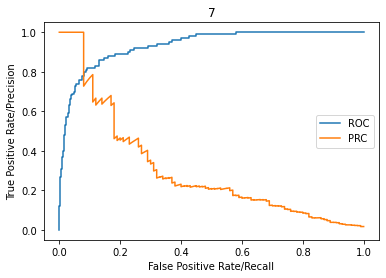

PRC AUC:0.30321990372233804
ROC AUC:0.9335676767676768


In [ ]:
fpr8, tpr8, thresholds8 = roc_curve(Y_test[:,7], probs[:, 7])
prec8, recall8, thresholds8 = precision_recall_curve(Y_test[:,7], probs[:, 7])

plt.plot(fpr8,tpr8,label="ROC")
plt.plot(recall8,prec8,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('7')
plt.show()

print("PRC AUC:" + str(auc(recall8, prec8)))
print("ROC AUC:" + str(auc(fpr8, tpr8)))

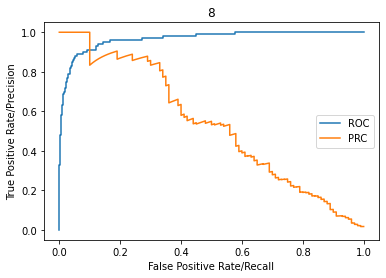

PRC AUC:0.5342120373475854
ROC AUC:0.9663525252525252


In [ ]:
fpr9, tpr9, thresholds9 = roc_curve(Y_test[:,8], probs[:, 8])
prec9, recall9, thresholds9 = precision_recall_curve(Y_test[:,8], probs[:, 8])

plt.plot(fpr9,tpr9,label="ROC")
plt.plot(recall9,prec9,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('8')
plt.show()

print("PRC AUC:" + str(auc(recall9, prec9)))
print("ROC AUC:" + str(auc(fpr9, tpr9)))

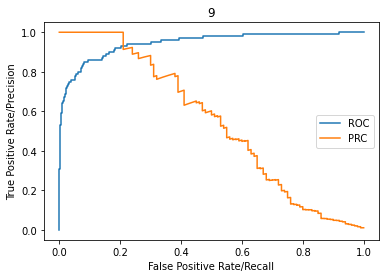

PRC AUC:0.5461615018847551
ROC AUC:0.9450060606060606


In [ ]:
fpr10, tpr10, thresholds10 = roc_curve(Y_test[:,9], probs[:, 9])
prec10, recall10, thresholds10 = precision_recall_curve(Y_test[:,9], probs[:, 9])

plt.plot(fpr10,tpr10,label="ROC")
plt.plot(recall10,prec10,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('9')
plt.show()

print("PRC AUC:" + str(auc(recall10, prec10)))
print("ROC AUC:" + str(auc(fpr10, tpr10)))

### ROC and PRC Curve 10-19

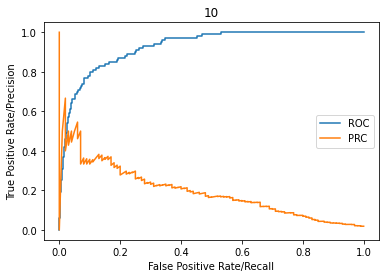

PRC AUC:0.19158130239388446
ROC AUC:0.9271868686868687


In [ ]:
fpr11, tpr11, thresholds11 = roc_curve(Y_test[:,10], probs[:,10])
prec11, recall11, thresholds11 = precision_recall_curve(Y_test[:,10], probs[:,10])

plt.plot(fpr11,tpr11,label="ROC")
plt.plot(recall11,prec11,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('10')
plt.show()

print("PRC AUC:" + str(auc(recall11, prec11)))
print("ROC AUC:" + str(auc(fpr11, tpr11)))

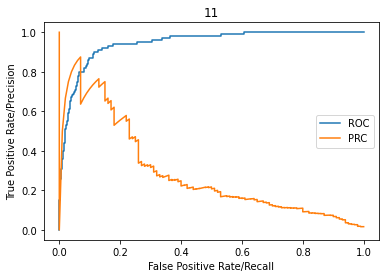

PRC AUC:0.2843696750772185
ROC AUC:0.9449131313131314


In [ ]:
fpr12, tpr12, thresholds12 = roc_curve(Y_test[:,11], probs[:, 11])
prec12, recall12, thresholds12 = precision_recall_curve(Y_test[:,11], probs[:, 11])

plt.plot(fpr12,tpr12,label="ROC")
plt.plot(recall12,prec12,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('11')
plt.show()

print("PRC AUC:" + str(auc(recall12, prec12)))
print("ROC AUC:" + str(auc(fpr12, tpr12)))

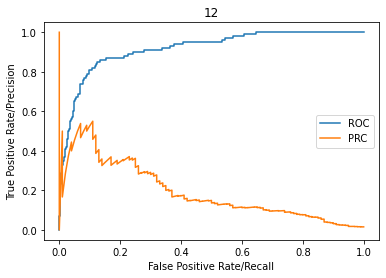

PRC AUC:0.18954130743368378
ROC AUC:0.9161121212121213


In [ ]:
fpr13, tpr13, thresholds13 = roc_curve(Y_test[:,12], probs[:, 12])
prec13, recall13, thresholds13 = precision_recall_curve(Y_test[:,12], probs[:, 12])

plt.plot(fpr13,tpr13,label="ROC")
plt.plot(recall13,prec13,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('12')
plt.show()

print("PRC AUC:" + str(auc(recall13, prec13)))
print("ROC AUC:" + str(auc(fpr13, tpr13)))

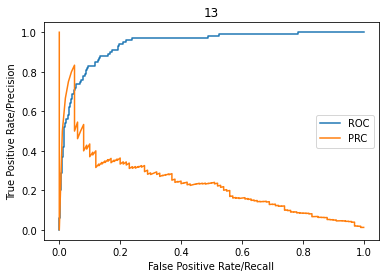

PRC AUC:0.2278504021977988
ROC AUC:0.9393383838383836


In [ ]:
fpr14, tpr14, thresholds14 = roc_curve(Y_test[:,13], probs[:, 13])
prec14, recall14, thresholds14 = precision_recall_curve(Y_test[:,13], probs[:, 13])

plt.plot(fpr14,tpr14,label="ROC")
plt.plot(recall14,prec14,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('13')
plt.show()

print("PRC AUC:" + str(auc(recall14, prec14)))
print("ROC AUC:" + str(auc(fpr14, tpr14)))

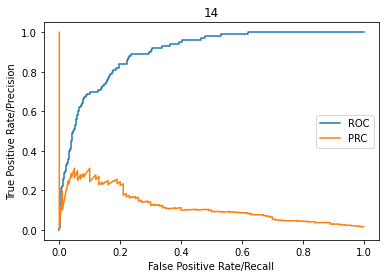

PRC AUC:0.11474012816335992
ROC AUC:0.8986818181818182


In [ ]:
fpr15, tpr15, thresholds15 = roc_curve(Y_test[:,14], probs[:, 14])
prec15, recall15, thresholds15 = precision_recall_curve(Y_test[:,14], probs[:, 14])

plt.plot(fpr15,tpr15,label="ROC")
plt.plot(recall15,prec15,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('14')
plt.show()

print("PRC AUC:" + str(auc(recall15, prec15)))
print("ROC AUC:" + str(auc(fpr15, tpr15)))

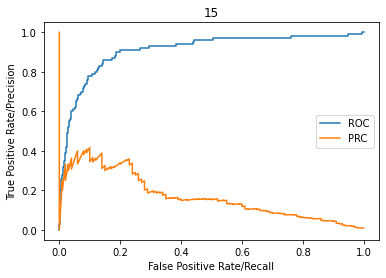

PRC AUC:0.16718850875306424
ROC AUC:0.9086505050505049


In [ ]:
fpr16, tpr16, thresholds16 = roc_curve(Y_test[:,15], probs[:, 15])
prec16, recall16, thresholds16 = precision_recall_curve(Y_test[:,15], probs[:, 15])

plt.plot(fpr16,tpr16,label="ROC")
plt.plot(recall16,prec16,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('15')
plt.show()

print("PRC AUC:" + str(auc(recall16, prec16)))
print("ROC AUC:" + str(auc(fpr16, tpr16)))

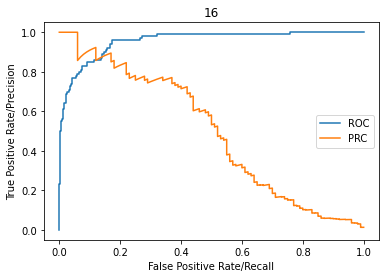

PRC AUC:0.4945245653200172
ROC AUC:0.9553383838383838


In [ ]:
fpr17, tpr17, thresholds17 = roc_curve(Y_test[:,16], probs[:, 16])
prec17, recall17, thresholds17 = precision_recall_curve(Y_test[:,16], probs[:, 16])

plt.plot(fpr17,tpr17,label="ROC")
plt.plot(recall17,prec17,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('16')
plt.show()

print("PRC AUC:" + str(auc(recall17, prec17)))
print("ROC AUC:" + str(auc(fpr17, tpr17)))

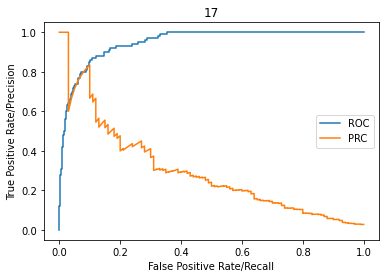

PRC AUC:0.2978554433983062
ROC AUC:0.9494727272727274


In [ ]:
fpr18, tpr18, thresholds18 = roc_curve(Y_test[:,17], probs[:, 17])
prec18, recall18, thresholds18 = precision_recall_curve(Y_test[:,17], probs[:, 17])

plt.plot(fpr18,tpr18,label="ROC")
plt.plot(recall18,prec18,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('17')
plt.show()

print("PRC AUC:" + str(auc(recall18, prec18)))
print("ROC AUC:" + str(auc(fpr18, tpr18)))

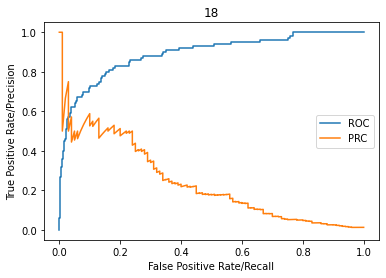

PRC AUC:0.23877672053348514
ROC AUC:0.8913444444444445


In [ ]:
fpr19, tpr19, thresholds19 = roc_curve(Y_test[:,18], probs[:, 18])
prec19, recall19, thresholds19 = precision_recall_curve(Y_test[:,18], probs[:, 18])

plt.plot(fpr19,tpr19,label="ROC")
plt.plot(recall19,prec19,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('18')
plt.show()

print("PRC AUC:" + str(auc(recall19, prec19)))
print("ROC AUC:" + str(auc(fpr19, tpr19)))

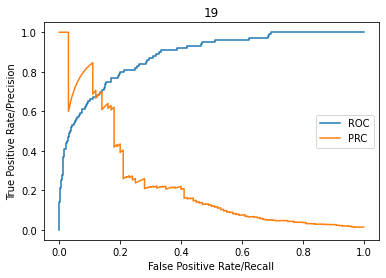

PRC AUC:0.23286190822590713
ROC AUC:0.8820646464646464


In [ ]:
fpr20, tpr20, thresholds20 = roc_curve(Y_test[:,19], probs[:, 19])
prec20, recall20, thresholds20 = precision_recall_curve(Y_test[:,19], probs[:, 19])

plt.plot(fpr20,tpr20,label="ROC")
plt.plot(recall20,prec20,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('19')
plt.show()

print("PRC AUC:" + str(auc(recall20, prec20)))
print("ROC AUC:" + str(auc(fpr20, tpr20)))

### ROC and PRC Curve 20-29

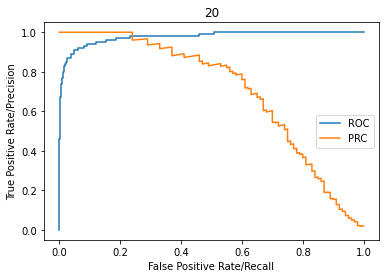

PRC AUC:0.7054232606262095
ROC AUC:0.9764686868686868


In [ ]:
fpr21, tpr21, thresholds21 = roc_curve(Y_test[:,20], probs[:,20])
prec21, recall21, thresholds21 = precision_recall_curve(Y_test[:,20], probs[:,20])

plt.plot(fpr21,tpr21,label="ROC")
plt.plot(recall21,prec21,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('20')
plt.show()

print("PRC AUC:" + str(auc(recall21, prec21)))
print("ROC AUC:" + str(auc(fpr21, tpr21)))

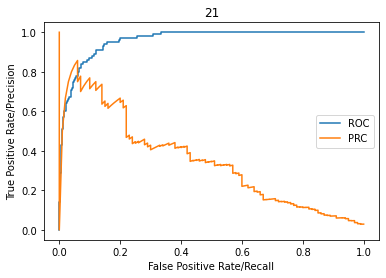

PRC AUC:0.34348704303075606
ROC AUC:0.9605474747474747


In [ ]:
fpr22, tpr22, thresholds22 = roc_curve(Y_test[:,21], probs[:, 21])
prec22, recall22, thresholds22 = precision_recall_curve(Y_test[:,21], probs[:, 21])

plt.plot(fpr22,tpr22,label="ROC")
plt.plot(recall22,prec22,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('21')
plt.show()

print("PRC AUC:" + str(auc(recall22, prec22)))
print("ROC AUC:" + str(auc(fpr22, tpr22)))

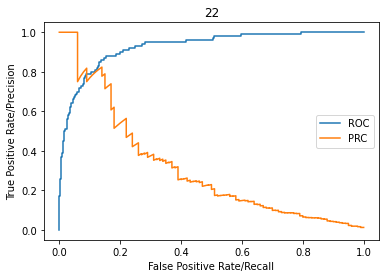

PRC AUC:0.3120930040800041
ROC AUC:0.927140404040404


In [ ]:
fpr23, tpr23, thresholds23 = roc_curve(Y_test[:,22], probs[:, 22])
prec23, recall23, thresholds23 = precision_recall_curve(Y_test[:,22], probs[:, 22])

plt.plot(fpr23,tpr23,label="ROC")
plt.plot(recall23,prec23,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('22')
plt.show()

print("PRC AUC:" + str(auc(recall23, prec23)))
print("ROC AUC:" + str(auc(fpr23, tpr23)))

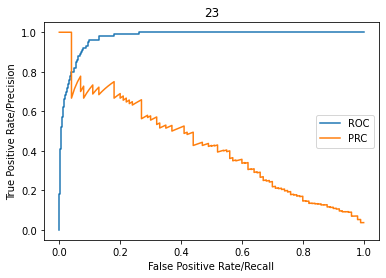

PRC AUC:0.42339087306630174
ROC AUC:0.9750929292929293


In [ ]:
fpr24, tpr24, thresholds24 = roc_curve(Y_test[:,23], probs[:, 23])
prec24, recall24, thresholds24 = precision_recall_curve(Y_test[:,23], probs[:, 23])

plt.plot(fpr24,tpr24,label="ROC")
plt.plot(recall24,prec24,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('23')
plt.show()

print("PRC AUC:" + str(auc(recall24, prec24)))
print("ROC AUC:" + str(auc(fpr24, tpr24)))

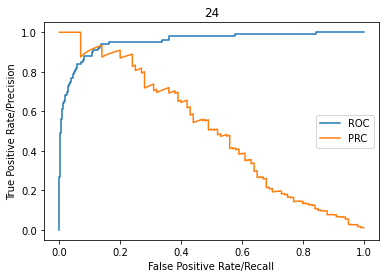

PRC AUC:0.5046644468122756
ROC AUC:0.9543212121212121


In [ ]:
fpr25, tpr25, thresholds25 = roc_curve(Y_test[:,24], probs[:, 24])
prec25, recall25, thresholds25 = precision_recall_curve(Y_test[:,24], probs[:, 24])

plt.plot(fpr25,tpr25,label="ROC")
plt.plot(recall25,prec25,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('24')
plt.show()

print("PRC AUC:" + str(auc(recall25, prec25)))
print("ROC AUC:" + str(auc(fpr25, tpr25)))

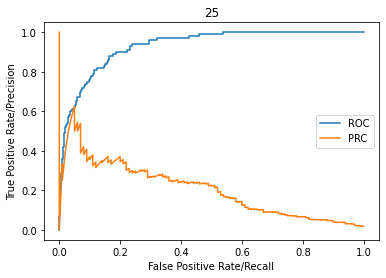

PRC AUC:0.2017360666086986
ROC AUC:0.9307404040404041


In [ ]:
fpr26, tpr26, thresholds26 = roc_curve(Y_test[:,25], probs[:, 25])
prec26, recall26, thresholds26 = precision_recall_curve(Y_test[:,25], probs[:, 25])

plt.plot(fpr26,tpr26,label="ROC")
plt.plot(recall26,prec26,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('25')
plt.show()

print("PRC AUC:" + str(auc(recall26, prec26)))
print("ROC AUC:" + str(auc(fpr26, tpr26)))

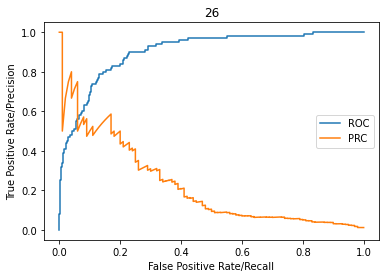

PRC AUC:0.22335619218018452
ROC AUC:0.9029919191919192


In [ ]:
fpr27, tpr27, thresholds27 = roc_curve(Y_test[:,26], probs[:, 26])
prec27, recall27, thresholds27 = precision_recall_curve(Y_test[:,26], probs[:, 26])

plt.plot(fpr27,tpr27,label="ROC")
plt.plot(recall27,prec27,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('26')
plt.show()

print("PRC AUC:" + str(auc(recall27, prec27)))
print("ROC AUC:" + str(auc(fpr27, tpr27)))

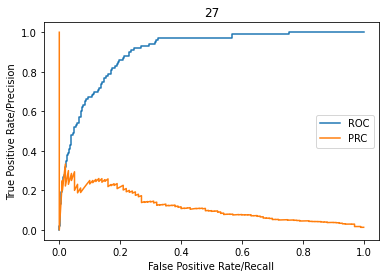

PRC AUC:0.11468828060386219
ROC AUC:0.9032626262626263


In [ ]:
fpr28, tpr28, thresholds28 = roc_curve(Y_test[:,27], probs[:, 27])
prec28, recall28, thresholds28 = precision_recall_curve(Y_test[:,27], probs[:, 27])

plt.plot(fpr28,tpr28,label="ROC")
plt.plot(recall28,prec28,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('27')
plt.show()

print("PRC AUC:" + str(auc(recall28, prec28)))
print("ROC AUC:" + str(auc(fpr28, tpr28)))

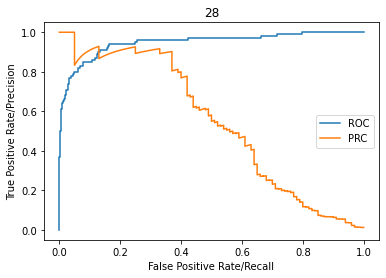

PRC AUC:0.5442009219241789
ROC AUC:0.9476898989898989


In [ ]:
fpr29, tpr29, thresholds29 = roc_curve(Y_test[:,28], probs[:, 28])
prec29, recall29, thresholds29 = precision_recall_curve(Y_test[:,28], probs[:, 28])

plt.plot(fpr29,tpr29,label="ROC")
plt.plot(recall29,prec29,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('28')
plt.show()

print("PRC AUC:" + str(auc(recall29, prec29)))
print("ROC AUC:" + str(auc(fpr29, tpr29)))

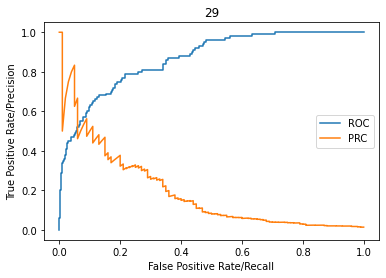

PRC AUC:0.1916010679568053
ROC AUC:0.8662959595959596


In [ ]:
fpr30, tpr30, thresholds30 = roc_curve(Y_test[:,29], probs[:, 29])
prec30, recall30, thresholds30 = precision_recall_curve(Y_test[:,29], probs[:, 29])

plt.plot(fpr30,tpr30,label="ROC")
plt.plot(recall30,prec30,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('29')
plt.show()

print("PRC AUC:" + str(auc(recall30, prec30)))
print("ROC AUC:" + str(auc(fpr30, tpr30)))

### ROC and PRC Curve 30-39

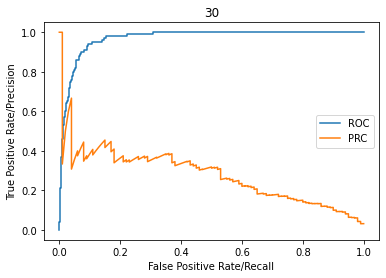

PRC AUC:0.276672595821892
ROC AUC:0.9692444444444444


In [ ]:
fpr31, tpr31, thresholds31 = roc_curve(Y_test[:,30], probs[:,30])
prec31, recall31, thresholds31 = precision_recall_curve(Y_test[:,30], probs[:,30])

plt.plot(fpr31,tpr31,label="ROC")
plt.plot(recall31,prec31,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('30')
plt.show()

print("PRC AUC:" + str(auc(recall31, prec31)))
print("ROC AUC:" + str(auc(fpr31, tpr31)))

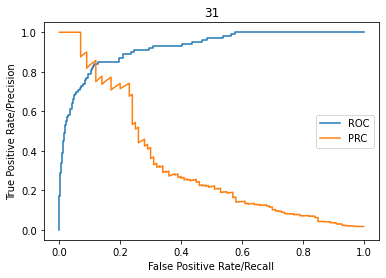

PRC AUC:0.3313773044533474
ROC AUC:0.9228727272727274


In [ ]:
fpr32, tpr32, thresholds32 = roc_curve(Y_test[:,31], probs[:, 31])
prec32, recall32, thresholds32 = precision_recall_curve(Y_test[:,31], probs[:, 31])

plt.plot(fpr32,tpr32,label="ROC")
plt.plot(recall32,prec32,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('31')
plt.show()

print("PRC AUC:" + str(auc(recall32, prec32)))
print("ROC AUC:" + str(auc(fpr32, tpr32)))

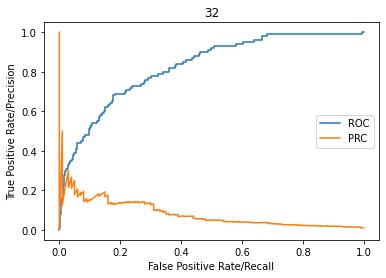

PRC AUC:0.07898300199993917
ROC AUC:0.8247969696969697


In [ ]:
fpr33, tpr33, thresholds33 = roc_curve(Y_test[:,32], probs[:, 32])
prec33, recall33, thresholds33 = precision_recall_curve(Y_test[:,32], probs[:, 32])

plt.plot(fpr33,tpr33,label="ROC")
plt.plot(recall33,prec33,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('32')
plt.show()

print("PRC AUC:" + str(auc(recall33, prec33)))
print("ROC AUC:" + str(auc(fpr33, tpr33)))

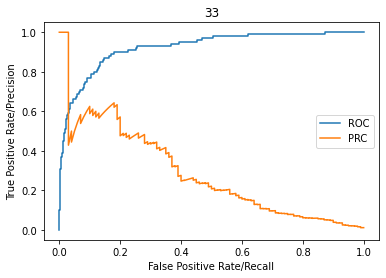

PRC AUC:0.28505789131407827
ROC AUC:0.9229919191919191


In [ ]:
fpr34, tpr34, thresholds34 = roc_curve(Y_test[:,33], probs[:, 33])
prec34, recall34, thresholds34 = precision_recall_curve(Y_test[:,33], probs[:, 33])

plt.plot(fpr34,tpr34,label="ROC")
plt.plot(recall34,prec34,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('33')
plt.show()

print("PRC AUC:" + str(auc(recall34, prec34)))
print("ROC AUC:" + str(auc(fpr34, tpr34)))

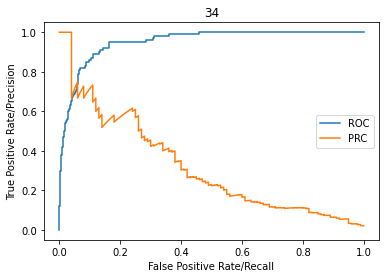

PRC AUC:0.31966207249813994
ROC AUC:0.9509616161616161


In [ ]:
fpr35, tpr35, thresholds35 = roc_curve(Y_test[:,34], probs[:, 34])
prec35, recall35, thresholds35 = precision_recall_curve(Y_test[:,34], probs[:, 34])

plt.plot(fpr35,tpr35,label="ROC")
plt.plot(recall35,prec35,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('34')
plt.show()

print("PRC AUC:" + str(auc(recall35, prec35)))
print("ROC AUC:" + str(auc(fpr35, tpr35)))

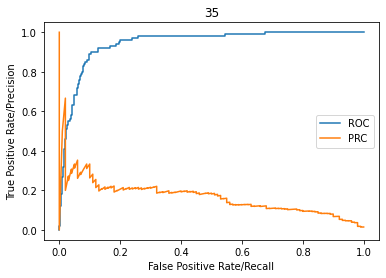

PRC AUC:0.16428798300107306
ROC AUC:0.9443515151515153


In [ ]:
fpr36, tpr36, thresholds36 = roc_curve(Y_test[:,35], probs[:, 35])
prec36, recall36, thresholds36 = precision_recall_curve(Y_test[:,35], probs[:, 35])

plt.plot(fpr36,tpr36,label="ROC")
plt.plot(recall36,prec36,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('35')
plt.show()

print("PRC AUC:" + str(auc(recall36, prec36)))
print("ROC AUC:" + str(auc(fpr36, tpr36)))

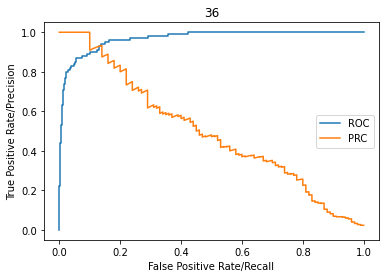

PRC AUC:0.49955043429613
ROC AUC:0.9682717171717171


In [ ]:
fpr37, tpr37, thresholds37 = roc_curve(Y_test[:,36], probs[:, 36])
prec37, recall37, thresholds37 = precision_recall_curve(Y_test[:,36], probs[:, 36])

plt.plot(fpr37,tpr37,label="ROC")
plt.plot(recall37,prec37,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('36')
plt.show()

print("PRC AUC:" + str(auc(recall37, prec37)))
print("ROC AUC:" + str(auc(fpr37, tpr37)))

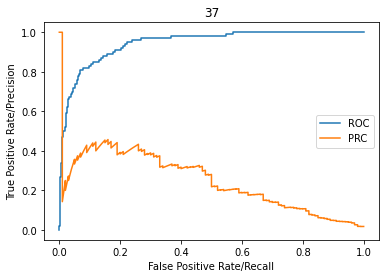

PRC AUC:0.2475910202262926
ROC AUC:0.9443292929292929


In [ ]:
fpr38, tpr38, thresholds38 = roc_curve(Y_test[:,37], probs[:, 37])
prec38, recall38, thresholds38 = precision_recall_curve(Y_test[:,37], probs[:, 37])

plt.plot(fpr38,tpr38,label="ROC")
plt.plot(recall38,prec38,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('37')
plt.show()

print("PRC AUC:" + str(auc(recall38, prec38)))
print("ROC AUC:" + str(auc(fpr38, tpr38)))

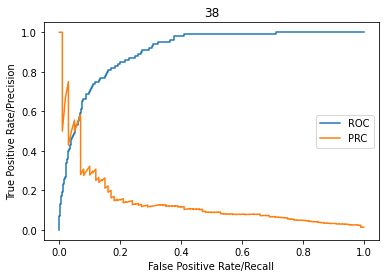

PRC AUC:0.1388953189467057
ROC AUC:0.9053878787878789


In [ ]:
fpr39, tpr39, thresholds39 = roc_curve(Y_test[:,38], probs[:, 38])
prec39, recall39, thresholds39 = precision_recall_curve(Y_test[:,38], probs[:, 38])

plt.plot(fpr39,tpr39,label="ROC")
plt.plot(recall39,prec39,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('38')
plt.show()

print("PRC AUC:" + str(auc(recall39, prec39)))
print("ROC AUC:" + str(auc(fpr39, tpr39)))

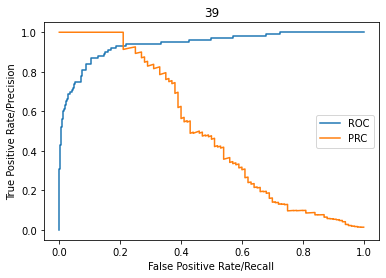

PRC AUC:0.4994476430133979
ROC AUC:0.9396171717171716


In [ ]:
fpr40, tpr40, thresholds40 = roc_curve(Y_test[:,39], probs[:, 39])
prec40, recall40, thresholds40 = precision_recall_curve(Y_test[:,39], probs[:, 39])

plt.plot(fpr40,tpr40,label="ROC")
plt.plot(recall40,prec40,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('39')
plt.show()

print("PRC AUC:" + str(auc(recall40, prec40)))
print("ROC AUC:" + str(auc(fpr40, tpr40)))

### ROC and PRC Curve 40-49

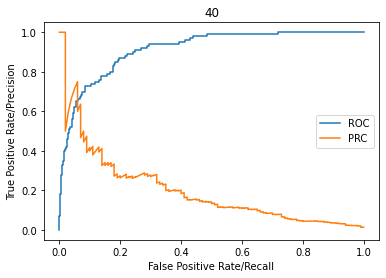

PRC AUC:0.20022107503400335
ROC AUC:0.9133171717171717


In [ ]:
fpr41, tpr41, thresholds41 = roc_curve(Y_test[:,40], probs[:,40])
prec41, recall41, thresholds41 = precision_recall_curve(Y_test[:,40], probs[:,40])

plt.plot(fpr41,tpr41,label="ROC")
plt.plot(recall41,prec41,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('40')
plt.show()

print("PRC AUC:" + str(auc(recall41, prec41)))
print("ROC AUC:" + str(auc(fpr41, tpr41)))

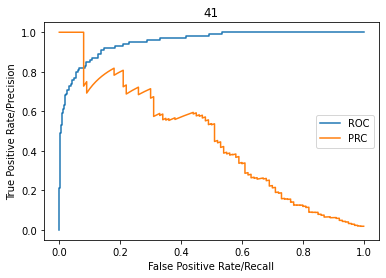

PRC AUC:0.4547575139232791
ROC AUC:0.9528737373737374


In [ ]:
fpr42, tpr42, thresholds42 = roc_curve(Y_test[:,41], probs[:, 41])
prec42, recall42, thresholds42 = precision_recall_curve(Y_test[:,41], probs[:, 41])

plt.plot(fpr42,tpr42,label="ROC")
plt.plot(recall42,prec42,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('41')
plt.show()

print("PRC AUC:" + str(auc(recall42, prec42)))
print("ROC AUC:" + str(auc(fpr42, tpr42)))

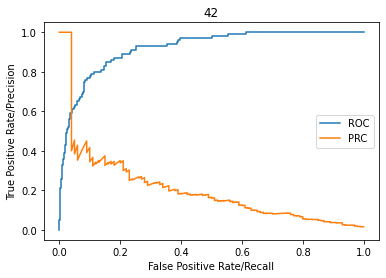

PRC AUC:0.20517730444984192
ROC AUC:0.920439393939394


In [ ]:
fpr43, tpr43, thresholds43 = roc_curve(Y_test[:,42], probs[:, 42])
prec43, recall43, thresholds43 = precision_recall_curve(Y_test[:,42], probs[:, 42])

plt.plot(fpr43,tpr43,label="ROC")
plt.plot(recall43,prec43,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('42')
plt.show()

print("PRC AUC:" + str(auc(recall43, prec43)))
print("ROC AUC:" + str(auc(fpr43, tpr43)))

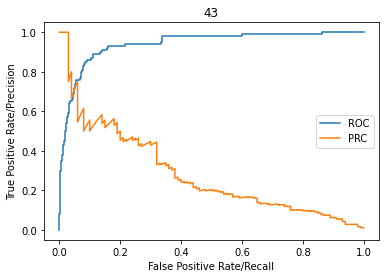

PRC AUC:0.28482049371221285
ROC AUC:0.940629292929293


In [ ]:
fpr44, tpr44, thresholds44 = roc_curve(Y_test[:,43], probs[:, 43])
prec44, recall44, thresholds44 = precision_recall_curve(Y_test[:,43], probs[:, 43])

plt.plot(fpr44,tpr44,label="ROC")
plt.plot(recall44,prec44,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('43')
plt.show()

print("PRC AUC:" + str(auc(recall44, prec44)))
print("ROC AUC:" + str(auc(fpr44, tpr44)))

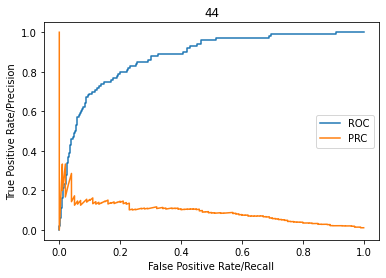

PRC AUC:0.08890625259679341
ROC AUC:0.8762414141414141


In [ ]:
fpr45, tpr45, thresholds45 = roc_curve(Y_test[:,44], probs[:, 44])
prec45, recall45, thresholds45 = precision_recall_curve(Y_test[:,44], probs[:, 44])

plt.plot(fpr45,tpr45,label="ROC")
plt.plot(recall45,prec45,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('44')
plt.show()

print("PRC AUC:" + str(auc(recall45, prec45)))
print("ROC AUC:" + str(auc(fpr45, tpr45)))

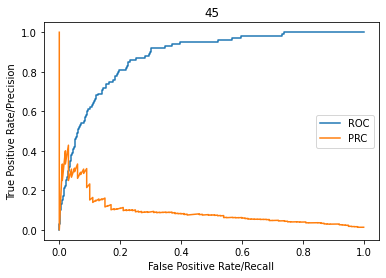

PRC AUC:0.08992501651794062
ROC AUC:0.8778898989898989


In [ ]:
fpr46, tpr46, thresholds46 = roc_curve(Y_test[:,45], probs[:, 45])
prec46, recall46, thresholds46 = precision_recall_curve(Y_test[:,45], probs[:, 45])

plt.plot(fpr46,tpr46,label="ROC")
plt.plot(recall46,prec46,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('45')
plt.show()

print("PRC AUC:" + str(auc(recall46, prec46)))
print("ROC AUC:" + str(auc(fpr46, tpr46)))

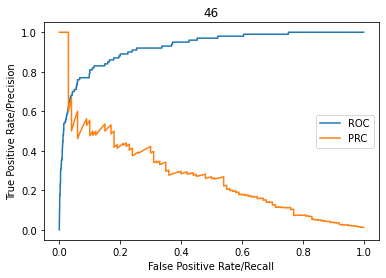

PRC AUC:0.27444162207046063
ROC AUC:0.92574898989899


In [ ]:
fpr47, tpr47, thresholds47 = roc_curve(Y_test[:,46], probs[:, 46])
prec47, recall47, thresholds47 = precision_recall_curve(Y_test[:,46], probs[:, 46])

plt.plot(fpr47,tpr47,label="ROC")
plt.plot(recall47,prec47,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('46')
plt.show()

print("PRC AUC:" + str(auc(recall47, prec47)))
print("ROC AUC:" + str(auc(fpr47, tpr47)))

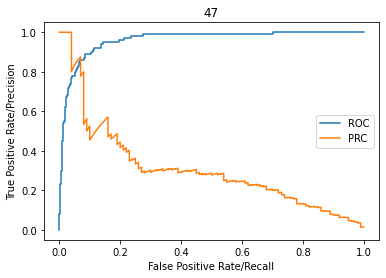

PRC AUC:0.30907173218098033
ROC AUC:0.9597242424242424


In [ ]:
fpr48, tpr48, thresholds48 = roc_curve(Y_test[:,47], probs[:, 47])
prec48, recall48, thresholds48 = precision_recall_curve(Y_test[:,47], probs[:, 47])

plt.plot(fpr48,tpr48,label="ROC")
plt.plot(recall48,prec48,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('47')
plt.show()

print("PRC AUC:" + str(auc(recall48, prec48)))
print("ROC AUC:" + str(auc(fpr48, tpr48)))

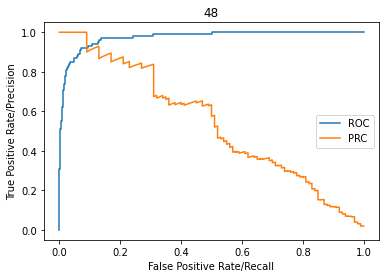

PRC AUC:0.5403991270396123
ROC AUC:0.9737080808080808


In [ ]:
fpr49, tpr49, thresholds49 = roc_curve(Y_test[:,48], probs[:, 48])
prec49, recall49, thresholds49 = precision_recall_curve(Y_test[:,48], probs[:, 48])

plt.plot(fpr49,tpr49,label="ROC")
plt.plot(recall49,prec49,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('48')
plt.show()

print("PRC AUC:" + str(auc(recall49, prec49)))
print("ROC AUC:" + str(auc(fpr49, tpr49)))

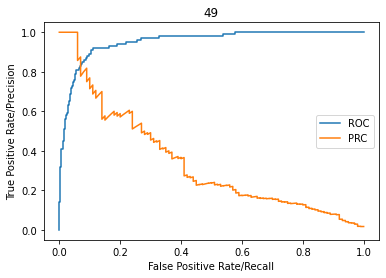

PRC AUC:0.341827730759281
ROC AUC:0.9522121212121213


In [ ]:
fpr50, tpr50, thresholds50 = roc_curve(Y_test[:,49], probs[:, 49])
prec50, recall50, thresholds50 = precision_recall_curve(Y_test[:,49], probs[:, 49])

plt.plot(fpr50,tpr50,label="ROC")
plt.plot(recall50,prec50,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('49')
plt.show()

print("PRC AUC:" + str(auc(recall50, prec50)))
print("ROC AUC:" + str(auc(fpr50, tpr50)))

## 50-99

### ROC and PRC Curves 50-59 

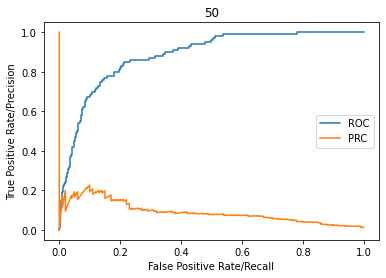

PRC AUC:0.08791721073827145
ROC AUC:0.8835989898989898


In [ ]:
fpr51, tpr51, thresholds51 = roc_curve(Y_test[:,50], probs[:,50])
prec51, recall51, thresholds51 = precision_recall_curve(Y_test[:,50], probs[:,50])

plt.plot(fpr51,tpr51,label="ROC")
plt.plot(recall51,prec51,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('50')
plt.show()

print("PRC AUC:" + str(auc(recall51, prec51)))
print("ROC AUC:" + str(auc(fpr51, tpr51)))

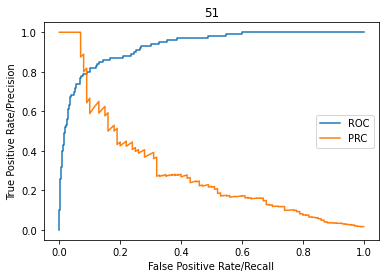

PRC AUC:0.29705656879387504
ROC AUC:0.9307191919191918


In [ ]:
fpr52, tpr52, thresholds52 = roc_curve(Y_test[:,51], probs[:, 51])
prec52, recall52, thresholds52 = precision_recall_curve(Y_test[:,51], probs[:, 51])

plt.plot(fpr52,tpr52,label="ROC")
plt.plot(recall52,prec52,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('51')
plt.show()

print("PRC AUC:" + str(auc(recall52, prec52)))
print("ROC AUC:" + str(auc(fpr52, tpr52)))

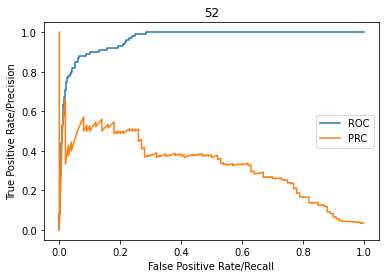

PRC AUC:0.32467962246304305
ROC AUC:0.9654949494949495


In [ ]:
fpr53, tpr53, thresholds53 = roc_curve(Y_test[:,52], probs[:, 52])
prec53, recall53, thresholds53 = precision_recall_curve(Y_test[:,52], probs[:, 52])

plt.plot(fpr53,tpr53,label="ROC")
plt.plot(recall53,prec53,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('52')
plt.show()

print("PRC AUC:" + str(auc(recall53, prec53)))
print("ROC AUC:" + str(auc(fpr53, tpr53)))

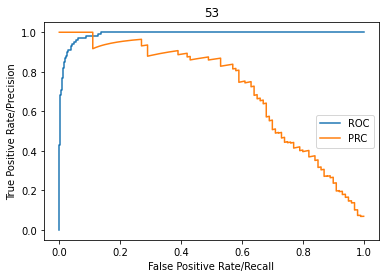

PRC AUC:0.7096811687458126
ROC AUC:0.9900525252525253


In [ ]:
fpr54, tpr54, thresholds54 = roc_curve(Y_test[:,53], probs[:, 53])
prec54, recall54, thresholds54 = precision_recall_curve(Y_test[:,53], probs[:, 53])

plt.plot(fpr54,tpr54,label="ROC")
plt.plot(recall54,prec54,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('53')
plt.show()

print("PRC AUC:" + str(auc(recall54, prec54)))
print("ROC AUC:" + str(auc(fpr54, tpr54)))

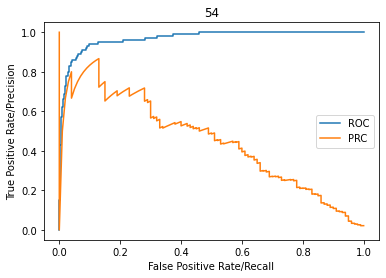

PRC AUC:0.4443120296353866
ROC AUC:0.9689262626262626


In [ ]:
fpr55, tpr55, thresholds55 = roc_curve(Y_test[:,54], probs[:, 54])
prec55, recall55, thresholds55 = precision_recall_curve(Y_test[:,54], probs[:, 54])

plt.plot(fpr55,tpr55,label="ROC")
plt.plot(recall55,prec55,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('54')
plt.show()

print("PRC AUC:" + str(auc(recall55, prec55)))
print("ROC AUC:" + str(auc(fpr55, tpr55)))

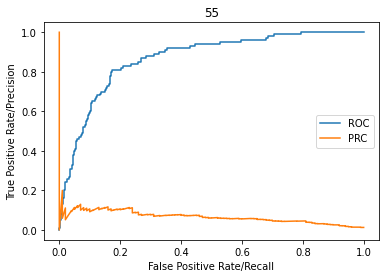

PRC AUC:0.06470072743235031
ROC AUC:0.8671040404040404


In [ ]:
fpr56, tpr56, thresholds56 = roc_curve(Y_test[:,55], probs[:, 55])
prec56, recall56, thresholds56 = precision_recall_curve(Y_test[:,55], probs[:, 55])

plt.plot(fpr56,tpr56,label="ROC")
plt.plot(recall56,prec56,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('55')
plt.show()

print("PRC AUC:" + str(auc(recall56, prec56)))
print("ROC AUC:" + str(auc(fpr56, tpr56)))

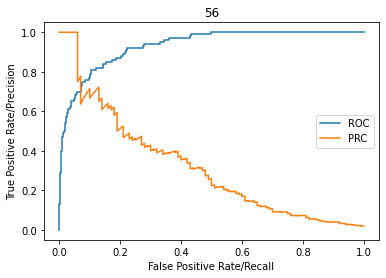

PRC AUC:0.31800441121984035
ROC AUC:0.932409090909091


In [ ]:
fpr57, tpr57, thresholds57 = roc_curve(Y_test[:,56], probs[:, 56])
prec57, recall57, thresholds57 = precision_recall_curve(Y_test[:,56], probs[:, 56])

plt.plot(fpr57,tpr57,label="ROC")
plt.plot(recall57,prec57,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('56')
plt.show()

print("PRC AUC:" + str(auc(recall57, prec57)))
print("ROC AUC:" + str(auc(fpr57, tpr57)))

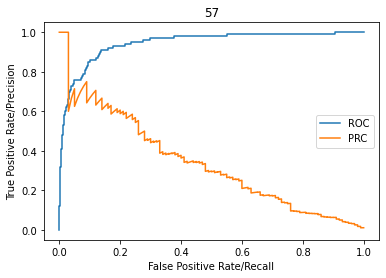

PRC AUC:0.3387410352924118
ROC AUC:0.9443292929292928


In [ ]:
fpr58, tpr58, thresholds58 = roc_curve(Y_test[:,57], probs[:, 57])
prec58, recall58, thresholds58 = precision_recall_curve(Y_test[:,57], probs[:, 57])

plt.plot(fpr58,tpr58,label="ROC")
plt.plot(recall58,prec58,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('57')
plt.show()

print("PRC AUC:" + str(auc(recall58, prec58)))
print("ROC AUC:" + str(auc(fpr58, tpr58)))

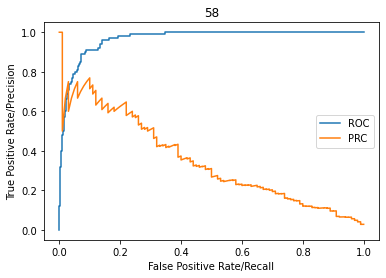

PRC AUC:0.35035229523468336
ROC AUC:0.9665646464646465


In [ ]:
fpr59, tpr59, thresholds59 = roc_curve(Y_test[:,58], probs[:, 58])
prec59, recall59, thresholds59 = precision_recall_curve(Y_test[:,58], probs[:, 58])

plt.plot(fpr59,tpr59,label="ROC")
plt.plot(recall59,prec59,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('58')
plt.show()

print("PRC AUC:" + str(auc(recall59, prec59)))
print("ROC AUC:" + str(auc(fpr59, tpr59)))

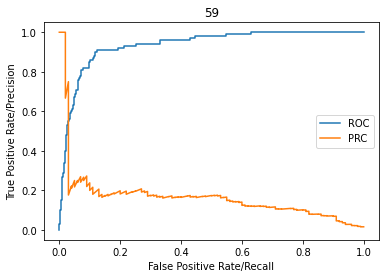

PRC AUC:0.16454121724695386
ROC AUC:0.9348171717171717


In [ ]:
fpr60, tpr60, thresholds60 = roc_curve(Y_test[:,59], probs[:, 59])
prec60, recall60, thresholds60 = precision_recall_curve(Y_test[:,59], probs[:, 59])

plt.plot(fpr60,tpr60,label="ROC")
plt.plot(recall60,prec60,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('59')
plt.show()

print("PRC AUC:" + str(auc(recall60, prec60)))
print("ROC AUC:" + str(auc(fpr60, tpr60)))

### ROC and PRC Curve 60-69

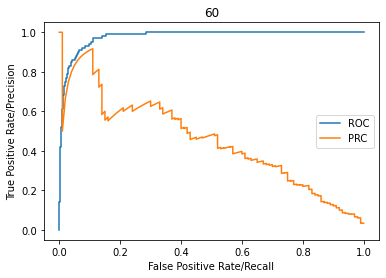

PRC AUC:0.45021553372041173
ROC AUC:0.9783181818181818


In [ ]:
fpr61, tpr61, thresholds61 = roc_curve(Y_test[:,60], probs[:,60])
prec61, recall61, thresholds61 = precision_recall_curve(Y_test[:,60], probs[:,60])

plt.plot(fpr61,tpr61,label="ROC")
plt.plot(recall61,prec61,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('60')
plt.show()

print("PRC AUC:" + str(auc(recall61, prec61)))
print("ROC AUC:" + str(auc(fpr61, tpr61)))

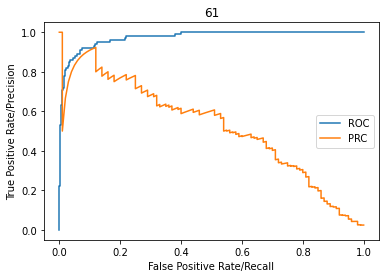

PRC AUC:0.5189167617743413
ROC AUC:0.9737777777777777


In [ ]:
fpr62, tpr62, thresholds62 = roc_curve(Y_test[:,61], probs[:, 61])
prec62, recall62, thresholds62 = precision_recall_curve(Y_test[:,61], probs[:, 61])

plt.plot(fpr62,tpr62,label="ROC")
plt.plot(recall62,prec62,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('61')
plt.show()

print("PRC AUC:" + str(auc(recall62, prec62)))
print("ROC AUC:" + str(auc(fpr62, tpr62)))

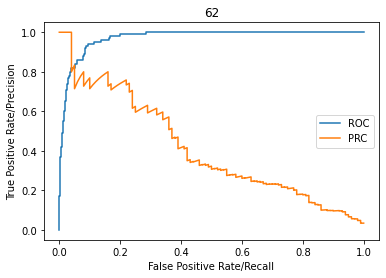

PRC AUC:0.41090882792786365
ROC AUC:0.972010101010101


In [ ]:
fpr63, tpr63, thresholds63 = roc_curve(Y_test[:,62], probs[:, 62])
prec63, recall63, thresholds63 = precision_recall_curve(Y_test[:,62], probs[:, 62])

plt.plot(fpr63,tpr63,label="ROC")
plt.plot(recall63,prec63,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('62')
plt.show()

print("PRC AUC:" + str(auc(recall63, prec63)))
print("ROC AUC:" + str(auc(fpr63, tpr63)))

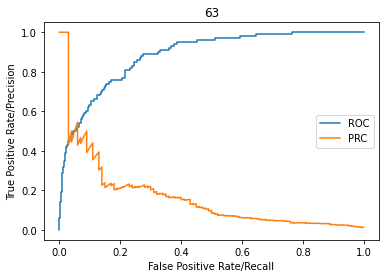

PRC AUC:0.16532534278414227
ROC AUC:0.8838959595959596


In [ ]:
fpr64, tpr64, thresholds64 = roc_curve(Y_test[:,63], probs[:, 63])
prec64, recall64, thresholds64 = precision_recall_curve(Y_test[:,63], probs[:, 63])

plt.plot(fpr64,tpr64,label="ROC")
plt.plot(recall64,prec64,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('63')
plt.show()

print("PRC AUC:" + str(auc(recall64, prec64)))
print("ROC AUC:" + str(auc(fpr64, tpr64)))

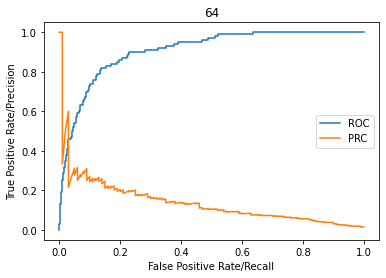

PRC AUC:0.13824131973792075
ROC AUC:0.9063848484848485


In [ ]:
fpr65, tpr65, thresholds65 = roc_curve(Y_test[:,64], probs[:, 64])
prec65, recall65, thresholds65 = precision_recall_curve(Y_test[:,64], probs[:, 64])

plt.plot(fpr65,tpr65,label="ROC")
plt.plot(recall65,prec65,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('64')
plt.show()

print("PRC AUC:" + str(auc(recall65, prec65)))
print("ROC AUC:" + str(auc(fpr65, tpr65)))

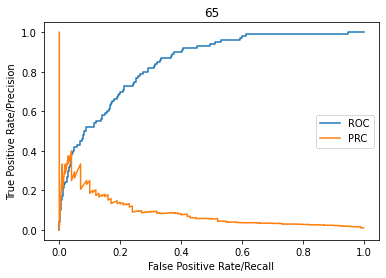

PRC AUC:0.08453207200718729
ROC AUC:0.8429525252525253


In [ ]:
fpr66, tpr66, thresholds66 = roc_curve(Y_test[:,65], probs[:, 65])
prec66, recall66, thresholds66 = precision_recall_curve(Y_test[:,65], probs[:, 65])

plt.plot(fpr66,tpr66,label="ROC")
plt.plot(recall66,prec66,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('65')
plt.show()

print("PRC AUC:" + str(auc(recall66, prec66)))
print("ROC AUC:" + str(auc(fpr66, tpr66)))

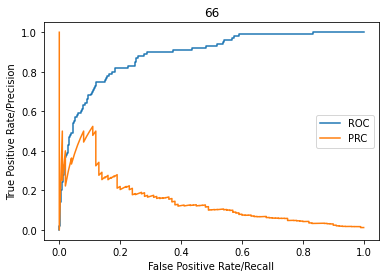

PRC AUC:0.1436580924879991
ROC AUC:0.8863787878787879


In [ ]:
fpr67, tpr67, thresholds67 = roc_curve(Y_test[:,66], probs[:, 66])
prec67, recall67, thresholds67 = precision_recall_curve(Y_test[:,66], probs[:, 66])

plt.plot(fpr67,tpr67,label="ROC")
plt.plot(recall67,prec67,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('66')
plt.show()

print("PRC AUC:" + str(auc(recall67, prec67)))
print("ROC AUC:" + str(auc(fpr67, tpr67)))

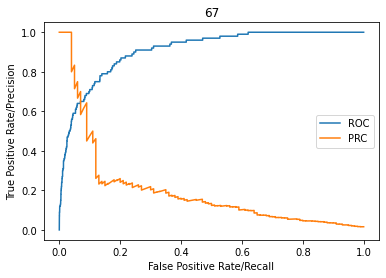

PRC AUC:0.1965782611244875
ROC AUC:0.9084459595959596


In [ ]:
fpr68, tpr68, thresholds68 = roc_curve(Y_test[:,67], probs[:, 67])
prec68, recall68, thresholds68 = precision_recall_curve(Y_test[:,67], probs[:, 67])

plt.plot(fpr68,tpr68,label="ROC")
plt.plot(recall68,prec68,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('67')
plt.show()

print("PRC AUC:" + str(auc(recall68, prec68)))
print("ROC AUC:" + str(auc(fpr68, tpr68)))

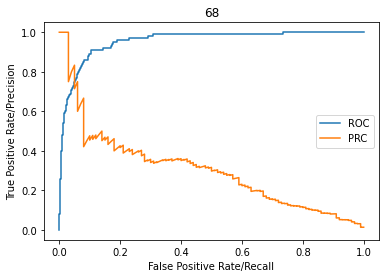

PRC AUC:0.30191238633607836
ROC AUC:0.9549989898989899


In [ ]:
fpr69, tpr69, thresholds69 = roc_curve(Y_test[:,68], probs[:, 68])
prec69, recall69, thresholds69 = precision_recall_curve(Y_test[:,68], probs[:, 68])

plt.plot(fpr69,tpr69,label="ROC")
plt.plot(recall69,prec69,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('68')
plt.show()

print("PRC AUC:" + str(auc(recall69, prec69)))
print("ROC AUC:" + str(auc(fpr69, tpr69)))

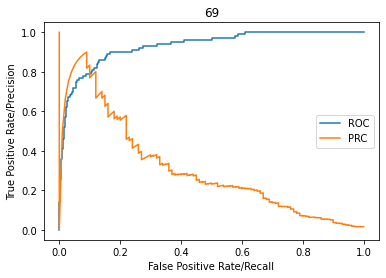

PRC AUC:0.30313148537199386
ROC AUC:0.9311232323232324


In [ ]:
fpr70, tpr70, thresholds70 = roc_curve(Y_test[:,69], probs[:, 69])
prec70, recall70, thresholds70 = precision_recall_curve(Y_test[:,69], probs[:, 69])

plt.plot(fpr70,tpr70,label="ROC")
plt.plot(recall70,prec70,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('69')
plt.show()

print("PRC AUC:" + str(auc(recall70, prec70)))
print("ROC AUC:" + str(auc(fpr70, tpr70)))

### ROC and PRC Curve 70-79

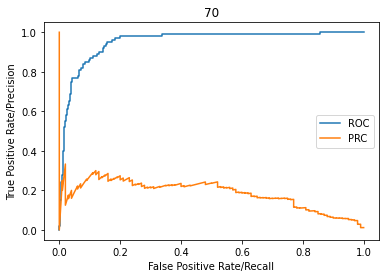

PRC AUC:0.18286132507957054
ROC AUC:0.9515333333333333


In [ ]:
fpr71, tpr71, thresholds71 = roc_curve(Y_test[:,70], probs[:,70])
prec71, recall71, thresholds71 = precision_recall_curve(Y_test[:,70], probs[:,70])

plt.plot(fpr71,tpr71,label="ROC")
plt.plot(recall71,prec71,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('70')
plt.show()

print("PRC AUC:" + str(auc(recall71, prec71)))
print("ROC AUC:" + str(auc(fpr71, tpr71)))

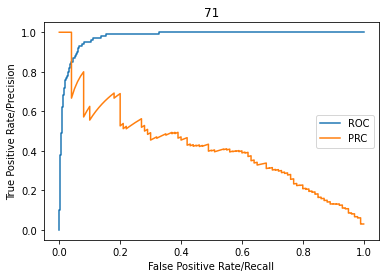

PRC AUC:0.4178704784064036
ROC AUC:0.9785232323232324


In [ ]:
fpr72, tpr72, thresholds72 = roc_curve(Y_test[:,71], probs[:, 71])
prec72, recall72, thresholds72 = precision_recall_curve(Y_test[:,71], probs[:, 71])

plt.plot(fpr72,tpr72,label="ROC")
plt.plot(recall72,prec72,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('71')
plt.show()

print("PRC AUC:" + str(auc(recall72, prec72)))
print("ROC AUC:" + str(auc(fpr72, tpr72)))

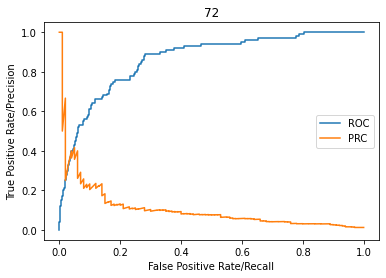

PRC AUC:0.10562855545215973
ROC AUC:0.8621585858585858


In [ ]:
fpr73, tpr73, thresholds73 = roc_curve(Y_test[:,72], probs[:, 72])
prec73, recall73, thresholds73 = precision_recall_curve(Y_test[:,72], probs[:, 72])

plt.plot(fpr73,tpr73,label="ROC")
plt.plot(recall73,prec73,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('72')
plt.show()

print("PRC AUC:" + str(auc(recall73, prec73)))
print("ROC AUC:" + str(auc(fpr73, tpr73)))

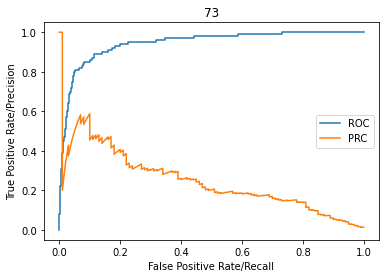

PRC AUC:0.2480769636798246
ROC AUC:0.9443262626262625


In [ ]:
fpr74, tpr74, thresholds74 = roc_curve(Y_test[:,73], probs[:, 73])
prec74, recall74, thresholds74 = precision_recall_curve(Y_test[:,73], probs[:, 73])

plt.plot(fpr74,tpr74,label="ROC")
plt.plot(recall74,prec74,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('73')
plt.show()

print("PRC AUC:" + str(auc(recall74, prec74)))
print("ROC AUC:" + str(auc(fpr74, tpr74)))

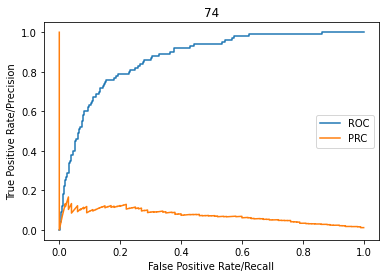

PRC AUC:0.07042676768303383
ROC AUC:0.8700080808080808


In [ ]:
fpr75, tpr75, thresholds75 = roc_curve(Y_test[:,74], probs[:, 74])
prec75, recall75, thresholds75 = precision_recall_curve(Y_test[:,74], probs[:, 74])

plt.plot(fpr75,tpr75,label="ROC")
plt.plot(recall75,prec75,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('74')
plt.show()

print("PRC AUC:" + str(auc(recall75, prec75)))
print("ROC AUC:" + str(auc(fpr75, tpr75)))

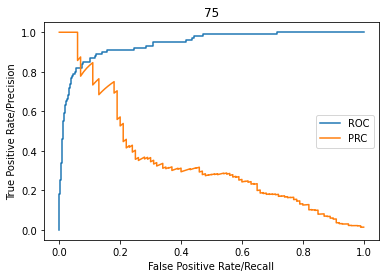

PRC AUC:0.34438697057360185
ROC AUC:0.9427777777777778


In [ ]:
fpr76, tpr76, thresholds76 = roc_curve(Y_test[:,75], probs[:, 75])
prec76, recall76, thresholds76 = precision_recall_curve(Y_test[:,75], probs[:, 75])

plt.plot(fpr76,tpr76,label="ROC")
plt.plot(recall76,prec76,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('75')
plt.show()

print("PRC AUC:" + str(auc(recall76, prec76)))
print("ROC AUC:" + str(auc(fpr76, tpr76)))

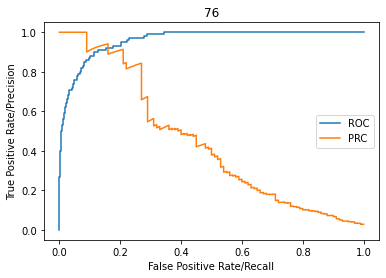

PRC AUC:0.4440716040513195
ROC AUC:0.9588666666666666


In [ ]:
fpr77, tpr77, thresholds77 = roc_curve(Y_test[:,76], probs[:, 76])
prec77, recall77, thresholds77 = precision_recall_curve(Y_test[:,76], probs[:, 76])

plt.plot(fpr77,tpr77,label="ROC")
plt.plot(recall77,prec77,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('76')
plt.show()

print("PRC AUC:" + str(auc(recall77, prec77)))
print("ROC AUC:" + str(auc(fpr77, tpr77)))

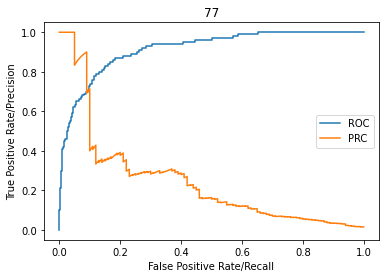

PRC AUC:0.2464901846628746
ROC AUC:0.9145575757575758


In [ ]:
fpr78, tpr78, thresholds78 = roc_curve(Y_test[:,77], probs[:, 77])
prec78, recall78, thresholds78 = precision_recall_curve(Y_test[:,77], probs[:, 77])

plt.plot(fpr78,tpr78,label="ROC")
plt.plot(recall78,prec78,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('77')
plt.show()

print("PRC AUC:" + str(auc(recall78, prec78)))
print("ROC AUC:" + str(auc(fpr78, tpr78)))

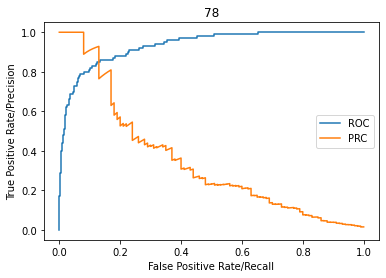

PRC AUC:0.3512981863642241
ROC AUC:0.9342060606060607


In [ ]:
fpr79, tpr79, thresholds79 = roc_curve(Y_test[:,78], probs[:, 78])
prec79, recall79, thresholds79 = precision_recall_curve(Y_test[:,78], probs[:, 78])

plt.plot(fpr79,tpr79,label="ROC")
plt.plot(recall79,prec79,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('78')
plt.show()

print("PRC AUC:" + str(auc(recall79, prec79)))
print("ROC AUC:" + str(auc(fpr79, tpr79)))

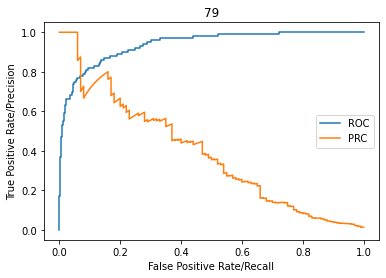

PRC AUC:0.38736121083187597
ROC AUC:0.9387424242424243


In [ ]:
fpr80, tpr80, thresholds80 = roc_curve(Y_test[:,79], probs[:, 79])
prec80, recall80, thresholds80 = precision_recall_curve(Y_test[:,79], probs[:, 79])

plt.plot(fpr80,tpr80,label="ROC")
plt.plot(recall80,prec80,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('79')
plt.show()

print("PRC AUC:" + str(auc(recall80, prec80)))
print("ROC AUC:" + str(auc(fpr80, tpr80)))

### ROC and PRC Curve 80-89

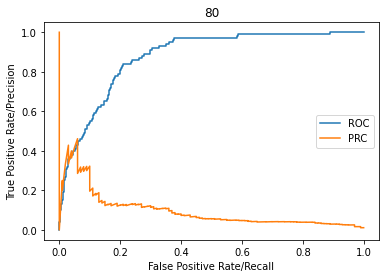

PRC AUC:0.09514383049377564
ROC AUC:0.8757747474747475


In [ ]:
fpr81, tpr81, thresholds81 = roc_curve(Y_test[:,80], probs[:,80])
prec81, recall81, thresholds81 = precision_recall_curve(Y_test[:,80], probs[:,80])

plt.plot(fpr81,tpr81,label="ROC")
plt.plot(recall81,prec81,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('80')
plt.show()

print("PRC AUC:" + str(auc(recall81, prec81)))
print("ROC AUC:" + str(auc(fpr81, tpr81)))

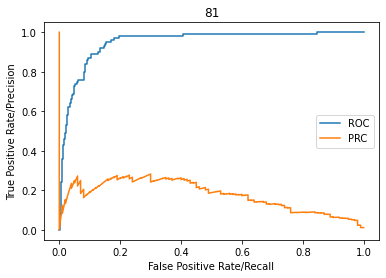

PRC AUC:0.17436315108295658
ROC AUC:0.948631313131313


In [ ]:
fpr82, tpr82, thresholds82 = roc_curve(Y_test[:,81], probs[:, 81])
prec82, recall82, thresholds82 = precision_recall_curve(Y_test[:,81], probs[:, 81])

plt.plot(fpr82,tpr82,label="ROC")
plt.plot(recall82,prec82,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('81')
plt.show()

print("PRC AUC:" + str(auc(recall82, prec82)))
print("ROC AUC:" + str(auc(fpr82, tpr82)))

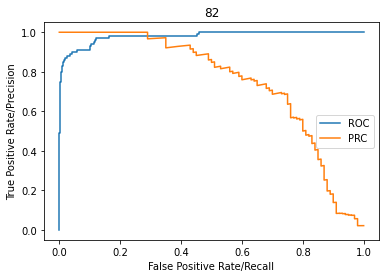

PRC AUC:0.7470204848710807
ROC AUC:0.9793222222222222


In [ ]:
fpr83, tpr83, thresholds83 = roc_curve(Y_test[:,82], probs[:, 82])
prec83, recall83, thresholds83 = precision_recall_curve(Y_test[:,82], probs[:, 82])

plt.plot(fpr83,tpr83,label="ROC")
plt.plot(recall83,prec83,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('82')
plt.show()

print("PRC AUC:" + str(auc(recall83, prec83)))
print("ROC AUC:" + str(auc(fpr83, tpr83)))

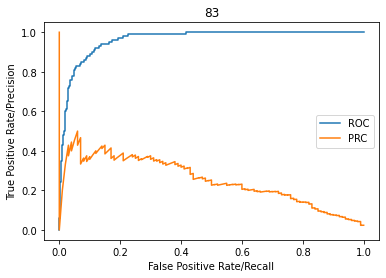

PRC AUC:0.24919297377197608
ROC AUC:0.9626181818181818


In [ ]:
fpr84, tpr84, thresholds84 = roc_curve(Y_test[:,83], probs[:, 83])
prec84, recall84, thresholds84 = precision_recall_curve(Y_test[:,83], probs[:, 83])

plt.plot(fpr84,tpr84,label="ROC")
plt.plot(recall84,prec84,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('83')
plt.show()

print("PRC AUC:" + str(auc(recall84, prec84)))
print("ROC AUC:" + str(auc(fpr84, tpr84)))

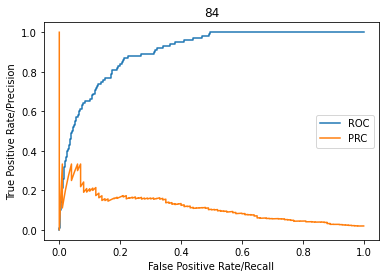

PRC AUC:0.11048213111385309
ROC AUC:0.9008949494949494


In [ ]:
fpr85, tpr85, thresholds85 = roc_curve(Y_test[:,84], probs[:, 84])
prec85, recall85, thresholds85 = precision_recall_curve(Y_test[:,84], probs[:, 84])

plt.plot(fpr85,tpr85,label="ROC")
plt.plot(recall85,prec85,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('84')
plt.show()

print("PRC AUC:" + str(auc(recall85, prec85)))
print("ROC AUC:" + str(auc(fpr85, tpr85)))

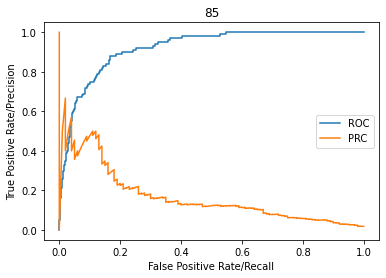

PRC AUC:0.16439323159584895
ROC AUC:0.9200838383838383


In [ ]:
fpr86, tpr86, thresholds86 = roc_curve(Y_test[:,85], probs[:, 85])
prec86, recall86, thresholds86 = precision_recall_curve(Y_test[:,85], probs[:, 85])

plt.plot(fpr86,tpr86,label="ROC")
plt.plot(recall86,prec86,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('85')
plt.show()

print("PRC AUC:" + str(auc(recall86, prec86)))
print("ROC AUC:" + str(auc(fpr86, tpr86)))

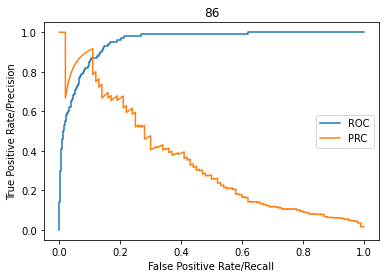

PRC AUC:0.346621058070699
ROC AUC:0.9526454545454546


In [ ]:
fpr87, tpr87, thresholds87 = roc_curve(Y_test[:,86], probs[:, 86])
prec87, recall87, thresholds87 = precision_recall_curve(Y_test[:,86], probs[:, 86])

plt.plot(fpr87,tpr87,label="ROC")
plt.plot(recall87,prec87,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('86')
plt.show()

print("PRC AUC:" + str(auc(recall87, prec87)))
print("ROC AUC:" + str(auc(fpr87, tpr87)))

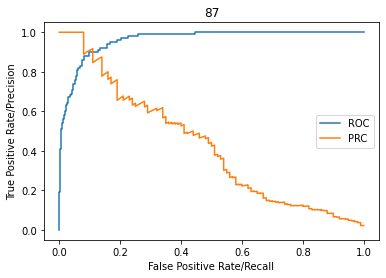

PRC AUC:0.42604603204376423
ROC AUC:0.9614575757575756


In [ ]:
fpr88, tpr88, thresholds88 = roc_curve(Y_test[:,87], probs[:, 87])
prec88, recall88, thresholds88 = precision_recall_curve(Y_test[:,87], probs[:, 87])

plt.plot(fpr88,tpr88,label="ROC")
plt.plot(recall88,prec88,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('87')
plt.show()

print("PRC AUC:" + str(auc(recall88, prec88)))
print("ROC AUC:" + str(auc(fpr88, tpr88)))

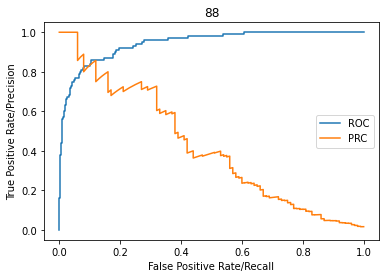

PRC AUC:0.42098820697867
ROC AUC:0.944520202020202


In [ ]:
fpr89, tpr89, thresholds89 = roc_curve(Y_test[:,88], probs[:, 88])
prec89, recall89, thresholds89 = precision_recall_curve(Y_test[:,88], probs[:, 88])

plt.plot(fpr89,tpr89,label="ROC")
plt.plot(recall89,prec89,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('88')
plt.show()

print("PRC AUC:" + str(auc(recall89, prec89)))
print("ROC AUC:" + str(auc(fpr89, tpr89)))

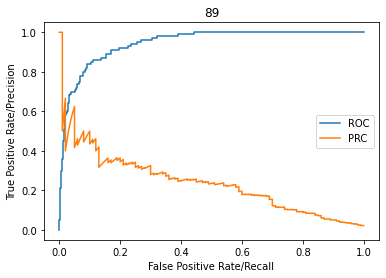

PRC AUC:0.23817962574396428
ROC AUC:0.9453939393939395


In [ ]:
fpr90, tpr90, thresholds90 = roc_curve(Y_test[:,89], probs[:, 89])
prec90, recall90, thresholds90 = precision_recall_curve(Y_test[:,89], probs[:, 89])

plt.plot(fpr90,tpr90,label="ROC")
plt.plot(recall90,prec90,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('89')
plt.show()

print("PRC AUC:" + str(auc(recall90, prec90)))
print("ROC AUC:" + str(auc(fpr90, tpr90)))

### ROC and PRC Curve 90-99

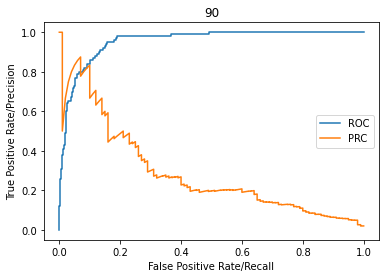

PRC AUC:0.28881850369263085
ROC AUC:0.9541363636363636


In [ ]:
fpr91, tpr91, thresholds91 = roc_curve(Y_test[:,90], probs[:,90])
prec91, recall91, thresholds91 = precision_recall_curve(Y_test[:,90], probs[:,90])

plt.plot(fpr91,tpr91,label="ROC")
plt.plot(recall91,prec91,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('90')
plt.show()

print("PRC AUC:" + str(auc(recall91, prec91)))
print("ROC AUC:" + str(auc(fpr91, tpr91)))

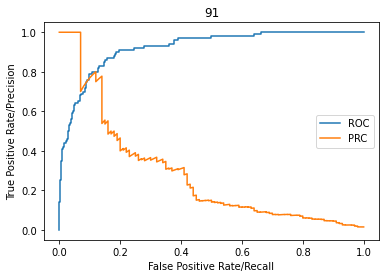

PRC AUC:0.28219833372105757
ROC AUC:0.9219939393939395


In [ ]:
fpr92, tpr92, thresholds92 = roc_curve(Y_test[:,91], probs[:, 91])
prec92, recall92, thresholds92 = precision_recall_curve(Y_test[:,91], probs[:, 91])

plt.plot(fpr92,tpr92,label="ROC")
plt.plot(recall92,prec92,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('91')
plt.show()

print("PRC AUC:" + str(auc(recall92, prec92)))
print("ROC AUC:" + str(auc(fpr92, tpr92)))

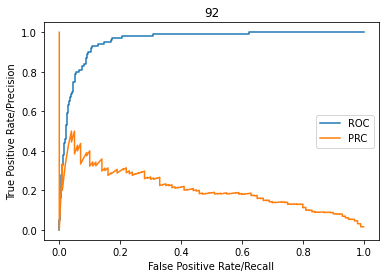

PRC AUC:0.20366792456524285
ROC AUC:0.9562414141414142


In [ ]:
fpr93, tpr93, thresholds93 = roc_curve(Y_test[:,92], probs[:, 92])
prec93, recall93, thresholds93 = precision_recall_curve(Y_test[:,92], probs[:, 92])

plt.plot(fpr93,tpr93,label="ROC")
plt.plot(recall93,prec93,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('92')
plt.show()

print("PRC AUC:" + str(auc(recall93, prec93)))
print("ROC AUC:" + str(auc(fpr93, tpr93)))

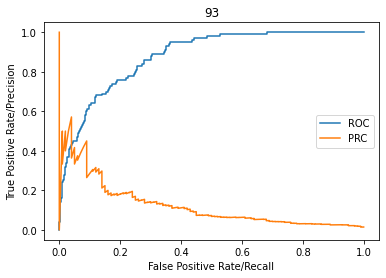

PRC AUC:0.12079355217720437
ROC AUC:0.8792696969696969


In [ ]:
fpr94, tpr94, thresholds94 = roc_curve(Y_test[:,93], probs[:, 93])
prec94, recall94, thresholds94 = precision_recall_curve(Y_test[:,93], probs[:, 93])

plt.plot(fpr94,tpr94,label="ROC")
plt.plot(recall94,prec94,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('93')
plt.show()

print("PRC AUC:" + str(auc(recall94, prec94)))
print("ROC AUC:" + str(auc(fpr94, tpr94)))

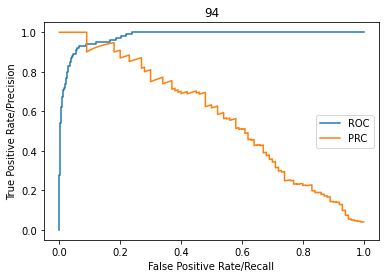

PRC AUC:0.5735148087265927
ROC AUC:0.9784828282828282


In [ ]:
fpr95, tpr95, thresholds95 = roc_curve(Y_test[:,94], probs[:, 94])
prec95, recall95, thresholds95 = precision_recall_curve(Y_test[:,94], probs[:, 94])

plt.plot(fpr95,tpr95,label="ROC")
plt.plot(recall95,prec95,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('94')
plt.show()

print("PRC AUC:" + str(auc(recall95, prec95)))
print("ROC AUC:" + str(auc(fpr95, tpr95)))

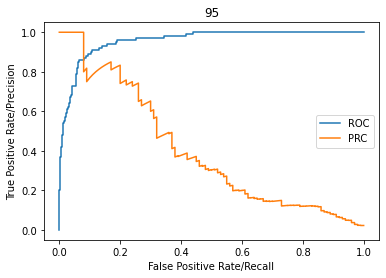

PRC AUC:0.39952788096102987
ROC AUC:0.9572727272727273


In [ ]:
fpr96, tpr96, thresholds96 = roc_curve(Y_test[:,95], probs[:, 95])
prec96, recall96, thresholds96 = precision_recall_curve(Y_test[:,95], probs[:, 95])

plt.plot(fpr96,tpr96,label="ROC")
plt.plot(recall96,prec96,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('95')
plt.show()

print("PRC AUC:" + str(auc(recall96, prec96)))
print("ROC AUC:" + str(auc(fpr96, tpr96)))

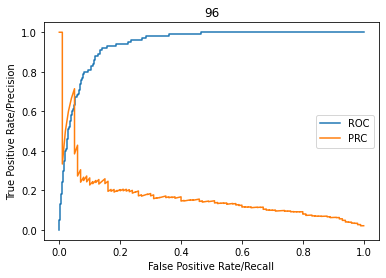

PRC AUC:0.16559856244780627
ROC AUC:0.9416585858585859


In [ ]:
fpr97, tpr97, thresholds97 = roc_curve(Y_test[:,96], probs[:, 96])
prec97, recall97, thresholds97 = precision_recall_curve(Y_test[:,96], probs[:, 96])

plt.plot(fpr97,tpr97,label="ROC")
plt.plot(recall97,prec97,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('96')
plt.show()

print("PRC AUC:" + str(auc(recall97, prec97)))
print("ROC AUC:" + str(auc(fpr97, tpr97)))

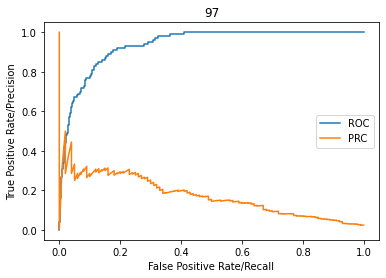

PRC AUC:0.17017923606503785
ROC AUC:0.9361797979797979


In [ ]:
fpr98, tpr98, thresholds28 = roc_curve(Y_test[:,97], probs[:, 97])
prec98, recall98, thresholds28 = precision_recall_curve(Y_test[:,97], probs[:, 97])

plt.plot(fpr98,tpr98,label="ROC")
plt.plot(recall98,prec98,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('97')
plt.show()

print("PRC AUC:" + str(auc(recall98, prec98)))
print("ROC AUC:" + str(auc(fpr98, tpr98)))

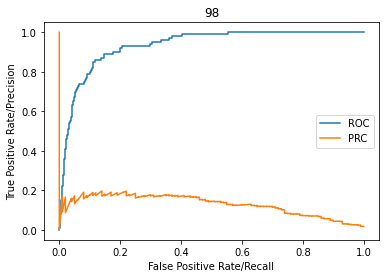

PRC AUC:0.12790617632965287
ROC AUC:0.9325737373737374


In [ ]:
fpr99, tpr99, thresholds99 = roc_curve(Y_test[:,98], probs[:, 98])
prec99, recall99, thresholds99 = precision_recall_curve(Y_test[:,98], probs[:, 98])

plt.plot(fpr99,tpr99,label="ROC")
plt.plot(recall99,prec99,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('98')
plt.show()

print("PRC AUC:" + str(auc(recall99, prec99)))
print("ROC AUC:" + str(auc(fpr99, tpr99)))

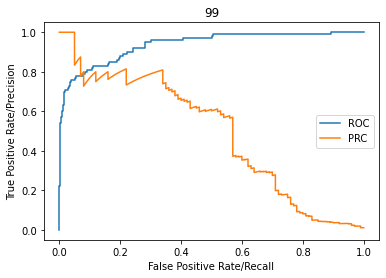

PRC AUC:0.4892959910315156
ROC AUC:0.936949494949495


In [ ]:
fpr100, tpr100, thresholds100 = roc_curve(Y_test[:,99], probs[:, 99])
prec100, recall100, thresholds100 = precision_recall_curve(Y_test[:,99], probs[:, 99])

plt.plot(fpr100,tpr100,label="ROC")
plt.plot(recall100,prec100,label="PRC")

plt.xlabel('False Positive Rate/Recall')
plt.ylabel('True Positive Rate/Precision')

plt.legend()
plt.title('99')
plt.show()

print("PRC AUC:" + str(auc(recall100, prec100)))
print("ROC AUC:" + str(auc(fpr100, tpr100)))